# Techniques of High Performance Computing - Assignment 3

**Name: John Duffy**

**Student Number: 19154676**

## Import Libraries Common to Questions 1 & 2

In [1]:
# Import libraries common to Questions 1 & 2.

import numpy as np
import pyopencl as cl

from scipy.sparse import coo_matrix
from scipy.sparse.linalg import LinearOperator, cg, spilu

%matplotlib inline
from matplotlib import pyplot as plt

# Question 1: Investigating Splitting Schemes

This question investigates the Laplace problem on a unit square with boundary conditions of u(x, 0) = 1, u(0, y) = 0, u(1, y) = 0 and u(x, 1) = 0. We consider the the discretisation of the problem in terms of a 5-point finite difference stencil, leading to the linear system of Ax = b, where b encodes the boundary data and A represents the discrete Laplacian operator.

We investigate this problem using Jacobi Iteration and Gauss-Seidel Iteration. The Gauss-Seidel Iteration investigates the problem with the averaging procedure starting with nodes at the bottom of the unit square, followed by starting with nodes at the top of the unit square. 

## Jacobi Iteration

The Jacobi Iteratiom method updates all of the discretisation points within the unit square in a single update. The order of updating each point is independent of all other points because each point is updated with "old" data from the input vector, u. This results in a high degree of potential parallelisation to exploit.

### Program Description

Due to the high degree of potential parallelisation available to exploit, the Jacobi Iteration method is ideal for implementing using an OpenCl kernel running on a GPU, with each discretisation point being updated in parallel. This is how this part of Question 1 has been implemented.

### Program Structure

The program is structured as a class called DiscreteLaplacian() which subclasses SciPy LinearOperator. This makes the class available to use as an input parameter to the SciPy cg iterative solver, as well as using simple repeated calls to the operator. The init and matvec LinearOperator methods are implemented to provide the Jacobi Iteration functionality.

#### The init Method

The init method takes a single parameter m which is the number of discretisation points of each side of the unit square. This parameter is used to set up the dimension of the operator.

Having set up the dimensions of the opersator, the method then creates an OpenCL GPU specific context and a command queue. Buffers are then created for the kernel input and output buffers. Note that the input buffer is READ ONLY and the ouput buffer is WRITE ONLY. This is good programming practice and prevents inadvertent corruption of the input data and subsequently the output data. The input parameter m is used to specify the sizes of these buffers.

The final action of the init method is to build the OpenCL kernel from the kernel string and store the kernal in an instance variable. This is a performance optimisation which prevents the kernel being built upon every call to the matvec method.

Note that in addition to the OpenCL kernel, instance variables are used to hold the operator dimension and references to the input and output vectors.

#### The matvec Method

The matvec method of the class is used to run an OpenCL kernel which implements the Jacobi Iteration. To do this the method copies the input vector from the host to the device, runs the OpenCL kernel on a global workspace of dimension m x m, with no local workspace defined, and then copies the output vector from the device to the host, and subsequently returns this vector as the result.

Using a global workspace of m x m, with no local workspace defined, runs the OpenCL kernel on every discretisation point in parallel exploiting the parallelism opportunity of Jacobi Iteration.

The input vector is copied from the host to the device using mapped input. This is a performance optimisation. 

#### The OpenCL Kernel

The OpenCL kernel takes the following as parameters:

- **const int m** The number of discretisation points on each side of the unit square
- **__global const float \*u** A pointer to the input vector array stored in global memory
- **__global float \*v** A pointer to the output vector stored in global memory

Note that the parameters m and u are declared const to avoid inadvertent data corruption. This is good programming practice.

The kernel is run in parallel for every discretisation point in using a global workspace. To determine which discretisation point a kernel instance is operating on the global ids are used to define row and column variables. These variables are then used to index the input and output vectors.

Because we do not want to change the boundary conditions, a check is done within the kernel using the row and column variables to ensure no changes are made to the boundary conditions. The input vector boundary conditions are copied directly to the output vector without modification.

The action of the kernel is to implement the stencil averaging procedure. This is carried out by indexing the input vector using offets calculated from the row and column variables, with the result of the averaging procedure being the value of the associated element of the ouput vector.

### Correctness Testing - By Hand Calculation

To ensure correctness of the Jacobi Iteration implementation, a unit sqaure with a small number of discretisation points was created with known values at each point. Hand calculations of the expected values of a single Jacobi Iteration were carried out, and then compared to a single application of the DiscreteLaplacian. The results, as shown below, confirm a correct implementation of Jacobi Iteration.

### Correctness Testing - Visually

For further visual correctness testing, plots of the unit square prior to and post application of the DiscreteLaplacian operator were made. These are also shown below. 

### Correctness Testing - Repeated Operator Invocations

To visually test the repeated application of the DiscreteLaplacian operator a series of plots was generated each depicting the result of an additional Jacobi Iteration. The plots are shown below.

## Gauss-Seidel Iteration - Numba Implementation

In the case of a unit square discretisation, the Gauss-Seidel Iteration method uses updated previous row data to update the current row. This serial updating of row data makes Gauss-Seidel Iteration unsuitable for the global parallelisation of each grid point as per Jacobi Iteration. So to investigate Gauss-Seidel Iteration a Numba implemention was developed which updates a single row at a time using just-in-time compilation to improve performance.

The Gauss-Seidel Iteration method commencing at the bottom and top unit square boundaries were investigated. 

### Program Description

The Gauss-Seidel Iteration uses data from a previously updated row to update the current row. To implement this each row is considered sequentially in turn, starting at either the bottom or top. Each row calculation averages "old" data from the input vector from the row above/below with "updated" data from the output vector from the row below/above.

The above procedure has the effect of transmitting information from the bottom to the top of the unit square, or vice versa, is a single iteration.

### Program Structure

The program is structured using three functions, gauss_seidel_iteration(), and gauss_seidel_up_update_row() and gauss_seidel_down_update_row().

The gauss_seidel_iteration() function is the main function which calls the gauss_seidel_up_update_row() or gauss_seidel_down_update_row() functions sequentially in row order dependent upon the **direction** parameter, respectively. The ...update_row() functions using "old" and "new" data from the rows above/below to implement the averaging procedure.

### Correctness Testing - By Hand Calculation

In a similar manner to the correctness testing of Jacobi Iteration, a unit square with a small number of discretisation points was considered for Gauss-Seidel Iteration in the updwards and downwards directions. For each up/down direction hand calculations were carried out to determine the expected output values from a single Gauss-Seidel Iteration. These hand calculated values were then compared to the computed ouput values to determine implemtation correctness. As can been seen from the data below, the implementation functions correctly.

As can be seen from the numerical values of this testing, in the upwards direction information is transmitted from bottom to top in a single iteration, whereas in the downwards direction information is transmitted only one row at a time in a single iteration. 

### Correctness Testing - Visually

As a visual test, plots of the unit square prior and post application of a single Gauss-Seidel iteration were made and plotted side-by-side for the up and down directions. These plots are depicted below. As can be seen visually, information is transmitted from bottom to top in a single iteration in the upwards direction, but only a single row at a time in the downwards direction.

### Correctness Testing - Repeated Operator Invocations

To compare the effect of multiple applications of the Gauss-Seidel Iteration method in the upwards and downward directions, plots were made side-by-side for both directions. These plots are depicted below.

## Jacobi and Gauss-Seidel Iteration Convergence Investigation

To compare the convergence rates of the Jacobi and Gauss-Seidel Iteration methods, an investigation was conducted for these methods (upwards and downwards for Gauss-Seidel) comparing the sum of the output vector v of each method for each iteration. The results of this investigation are presented in plots in the Convergence Investigation section below.

## Gauss-Seidel Iteration - Relaxed OpenCL Implementation

As previously stated, because the Gauss-Seidel Iteration method (both upwards and downwards) requires information from previsously updated rows to calculate the current row, this method is inherently serial and is not suitable for parallel calculation of all the discretisation points. However, within a single row there is the opportunity to update each elelement of the row in parallel.  

### Program Description

To implement a Relaxed OpenCL version of the Gauss-Seidel Iteration method an OpenCL kernel is used to update one row at a time. The kernel is passed 3 rows, the row to be updated an the row above and below. Each row is processed in turn using a normal for loop embedded within a main function.

As per the Numba implementation, the main function takes a 'up' or 'down' direction parameter.

## Gauss-Seidel Iteration and Relaxed OpenCL Iteration Convergence Investigation

A convergence investigation was conducted to compare the standard Gauss-Seidel Iteration method with the Relaxed OpenCL method. A plot and discussion of the results is included in the relevant section below. 


## Jacobi Iteration

In [2]:
# Define the OpenCL kernel string used in the class DiscreteLaplacian. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void discrete_laplacian(const int m, __global const float *u, __global float *v)
{
    // Retrieve the row and column indexes from the global id's.
    
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // Don't change the boundary conditions.
    
    if (r == 0 || r == m - 1 || c == 0 || c == m - 1) {
        v[m * r + c] = u[m * r + c];
        return;
    } 
    
    // Implement the averaging formula for the interior points.

    v[m * r + c] = (u[m * (r + 1) + c] + u[m * (r - 1) + c] + u[m * r + (c + 1)] + u[m * r + (c - 1)]) / 4.0f;
}

"""


# Define the class DiscreteLaplacian.

class DiscreteLaplacian(LinearOperator):
    """
    """
    
    def __init__(self, m):
        """
        """
        
        # Store the size m as an instance variable for access by class methods.
        
        self._m = m
        
        
        # Attributes required to be declared by LinearOperator.
        
        self.shape = (m * m, m * m)
        
        self.dytpe = np.float32
        

        # Create a GPU specific context and command queue.
        
        self._ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self._queue = cl.CommandQueue(self._ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 

        # Create input and output buffers, u and v. Note: u is READ_ONLY and v is WRITE_ONLY.
 
        self._u = cl.Buffer(self._ctx, cl.mem_flags.READ_ONLY, size = np.dtype(np.float32).itemsize * m * m)
        
        self._v = cl.Buffer(self._ctx, cl.mem_flags.WRITE_ONLY, size = np.dtype(np.float32).itemsize * m * m)
        

        # Build the kernel.
        
        self._kernel = cl.Program(self._ctx, kernel_string).build().discrete_laplacian

    
    def _matvec(self, u):
        """
        """

        # Use mapped input to efficiently copy the input vector u to the device.
        
        mapped_input, _ = cl.enqueue_map_buffer(self._queue, self._u, cl.map_flags.WRITE, 0, self._m * self._m, np.float32)
        
        with mapped_input.base:
            mapped_input[:] = u.astype(np.float32)


        # Run the kernel across all grid points in parallel using a global workspace m x m. 
            
        self._kernel(self._queue, (self._m, self._m), None, np.int32(self._m), self._u, self._v)


        # Create an output vector v and copy the output from the device.
                     
        v = np.zeros((self._m, self._m), dtype=np.float32)

        cl.enqueue_copy(self._queue, v, self._v)
                     

        # Return v as the correct datatype.
            
        return v.astype(np.float32)

### Correctness Testing - By Hand Calculation

In [3]:
# Test the class DiscreteLaplacian.

M = 5

# Generate test data with boundary conditions as per Question 1.

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M - 1] = 0.0
u[M - 1, :] = 1.0

print(u)

# Execute one application of the DiscreteLaplacian operator.

laplacian = DiscreteLaplacian(M)

v = laplacian(u.flatten()).reshape(M, M)

print(v)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.  ]
 [1.   1.   1.   1.   1.  ]]


As can been seen by comparing hand calculated values of v with the output from the operator, the operator is operating correctly. Because the Jacobi iteration is based upon "old" data, information is transmitted from the lower boundary to towards the top boundary in single steps row by row.

### Correctness Testing - Visually

In [4]:
# Declare plotting functions.

def plot(v, title, iteration):
    """
    This function...
    """
    plt.figure(figsize=(6, 5))
    plt.imshow(v, extent=[0, 1, 0, 1], origin='upper', cmap='Reds')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Iteration: ' + str(iteration))
    plt.show()
    
def plot_side_by_side(v_upwards, v_downwards, title, iteration):
    """
    This function...
    """
    plt.figure(figsize=(13, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(v_upwards, extent=[0, 1, 0, 1], cmap='Reds')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Up Iteration: ' + str(iteration))

    plt.subplot(1, 2, 2)
    plt.imshow(v_downwards, extent=[0, 1, 0, 1], cmap='Reds')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Down Iteration: ' + str(iteration))

    plt.tight_layout()
    plt.show()

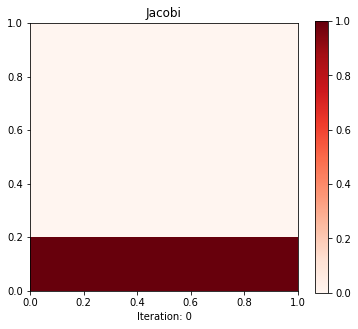

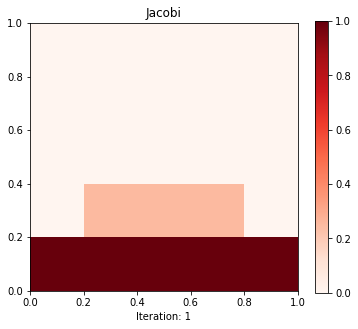

In [5]:
# Plot the previously used values of u and v.

plot(u, 'Jacobi', 0)
plot(v, 'Jacobi', 1)

As can been seen from the two plots above, u is the initial matrix and v is the result of a single application of the operator. This result is as expected and consistent with the hand claculated values expected of v.

### Correctness Testing - Repeated Operator Invocations

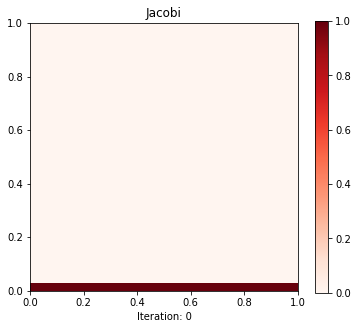

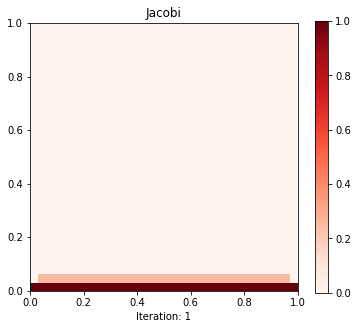

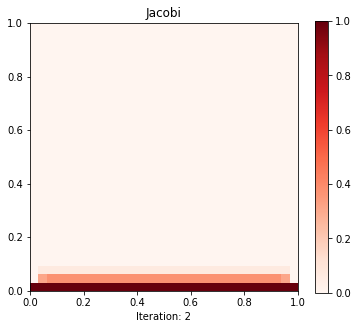

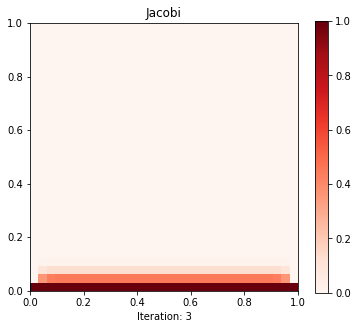

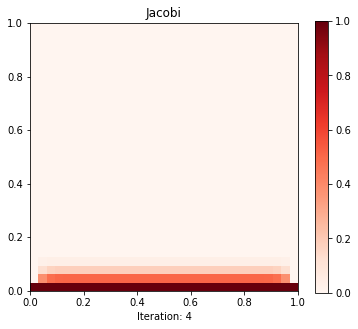

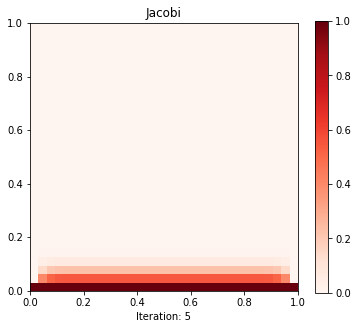

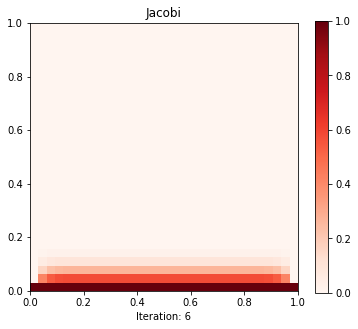

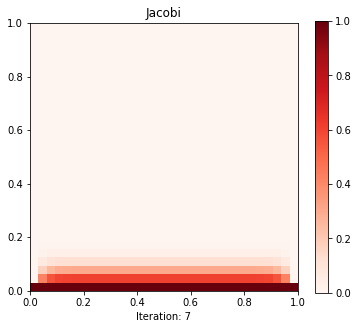

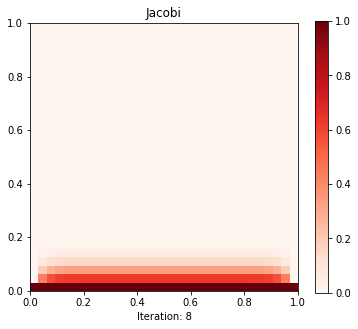

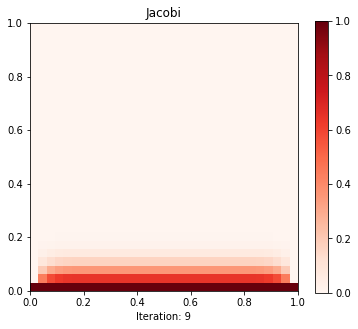

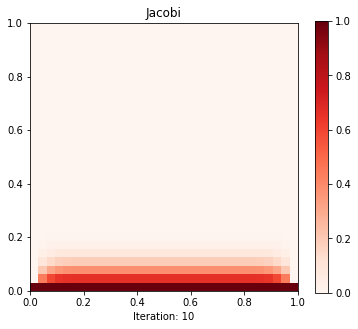

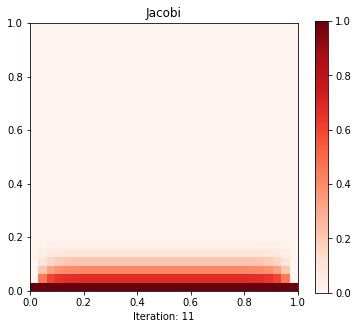

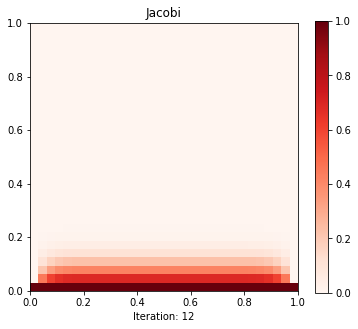

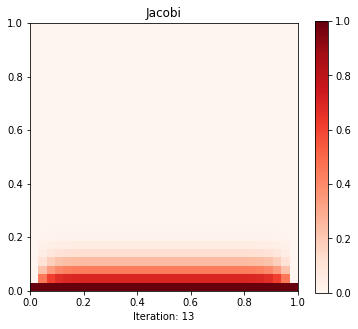

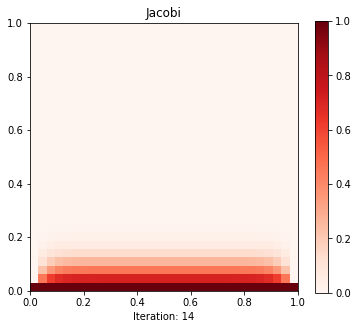

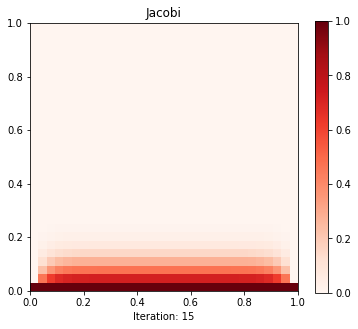

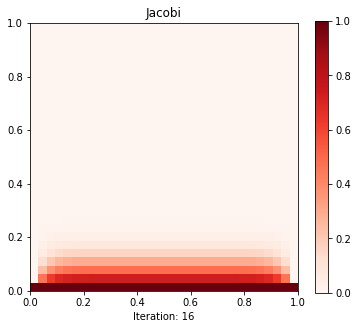

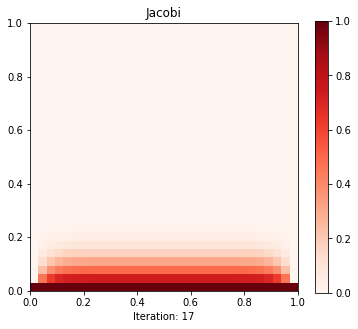

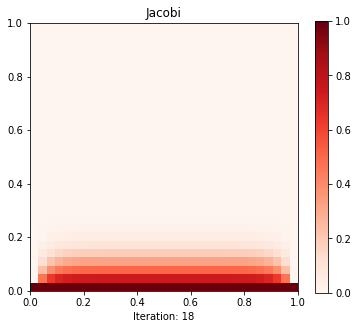

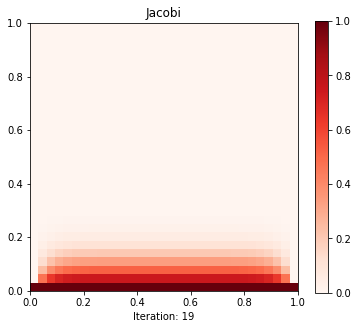

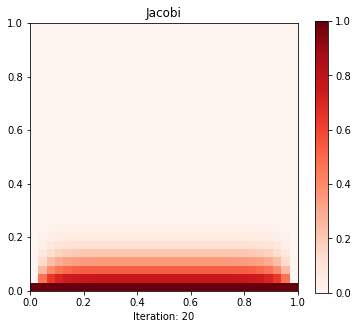

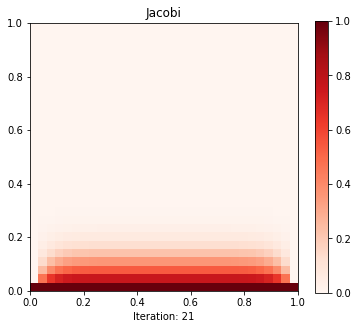

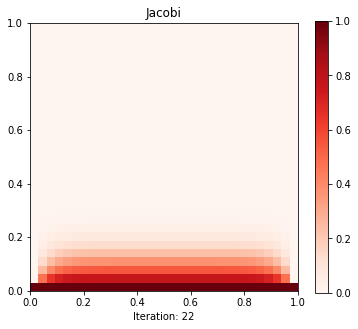

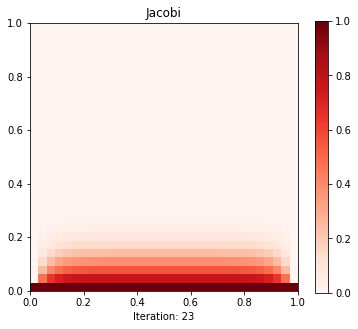

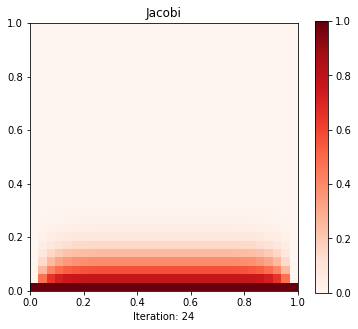

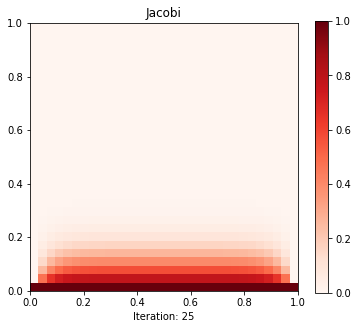

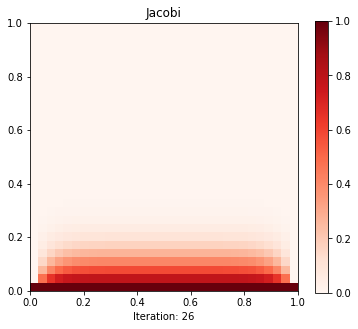

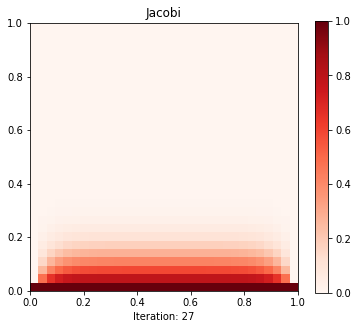

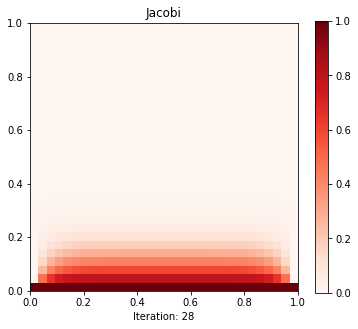

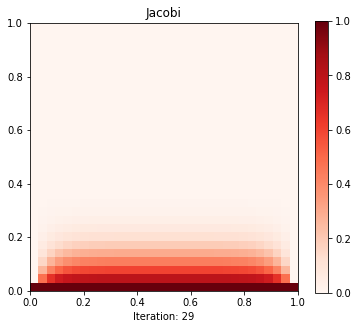

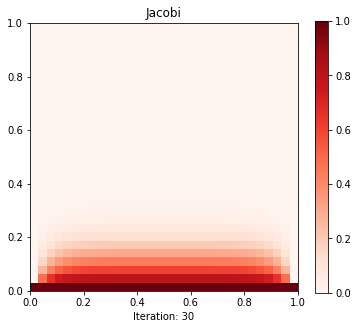

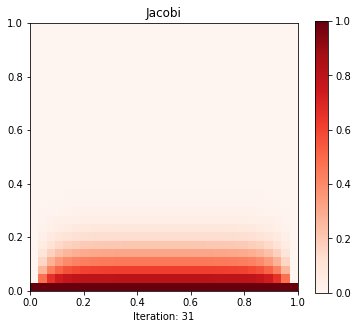

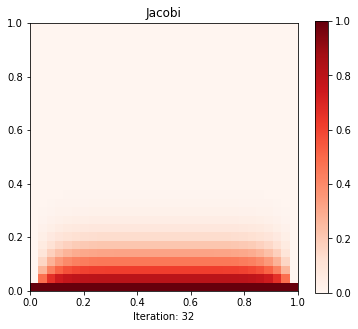

In [6]:
# Repeated calls to DiscreteLaplacian operator.

M = 32

ITERATIONS = 32

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

laplacian = DiscreteLaplacian(M)

plot(u, 'Jacobi', 0)

for i in range(ITERATIONS):
    v = laplacian(u.flatten()).reshape(M, M)
    plot(v, 'Jacobi', i + 1)
    u = v

As can be seen from the series of plots above, as expected, Jacobi iterations transmit information in single steps row by row from the botton to the top boundary.

## Gauss-Seidel Iteration - Numba Implementation

The following code implements Gauss-Seidel iterations both upwards and downwards using Numba to improve performance. The functions below are written in as simple 'C' like code as possible to enable just-in-time compilation using the @njit decorator.

In [7]:
from numba import njit

@njit
def gauss_seidel_up_update_row(m, u, v, row):
    """
    This function implements an upwards row iteration. Note the subtle accessing of u and v.
    """
    for col in range(1, m - 1):
        v[row, col] = (v[row + 1, col] + u[row - 1, col] + u[row, col + 1] + u[row, col - 1]) / 4.0

@njit
def gauss_seidel_down_update_row(m, u, v, row):
    """
    This function implements a downwards row iteration. Note the subtle accessing of u and v.
    """
    for col in range(1, m - 1):
        v[row, col] = (u[row + 1, col] + v[row - 1, col] + u[row, col + 1] + u[row, col - 1]) / 4.0

In [8]:
@njit
def gauss_seidel_iteration(m, u, v, direction='up'):
    """
    This function funtion implements an 'up' or 'down' Gauss-Seidel iteration of the input
    vector u, returning the result in vector u. The direction is selection by the named 
    'direction' parameter and the appropriate function is selected based upon the value
    of this parameter.
    """

    if (direction == 'up'):
        for row in range(m - 2, 0, -1):
            gauss_seidel_up_update_row(m, u, v, row)
            
    if (direction == 'down'):
        for row in range(1, m - 1):
            gauss_seidel_down_update_row(m, u, v, row)

    return v

### Correctness Testing - By Hand Calculation

In [9]:
M = 5

# Create a test input vector u setting the boundary conditions.

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

# Create the output vectors v_up and v_down.

v_up = np.copy(u)
v_down = np.copy(u)

# Call the Gauss-Seidel iteration function both up and down.

gauss_seidel_iteration(M, u, v_up, 'up')
gauss_seidel_iteration(M, u, v_down, 'down')

print(u)
print(v_up)
print(v_down)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
[[0.       0.       0.       0.       0.      ]
 [0.       0.015625 0.015625 0.015625 0.      ]
 [0.       0.0625   0.0625   0.0625   0.      ]
 [0.       0.25     0.25     0.25     0.      ]
 [1.       1.       1.       1.       1.      ]]
[[0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.  ]
 [1.   1.   1.   1.   1.  ]]


As can be seen by comparing hand calculated expected values with the values of v_up and v_down the function gauss_seidel_iteration() is operating correctly. Note that the 'up' iteration transmits data from the bottom
to the top boundary in a single call. Similar to Jacobi, the 'down' iteration only transmits data a single row
at a time.

### Correctness Testing - Visually

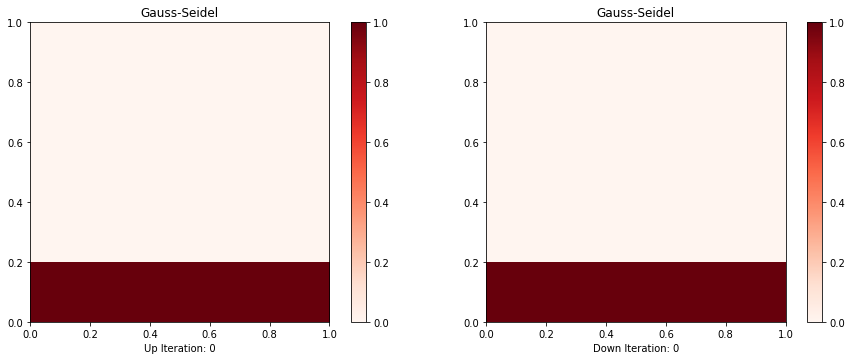

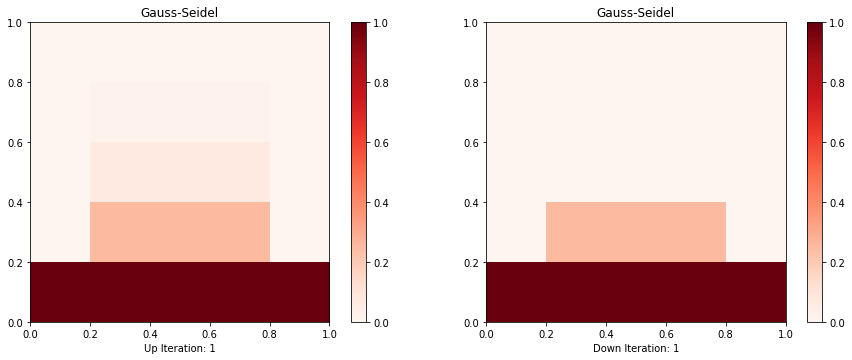

In [10]:
M = 5

# Create a test input vector u setting the boundary conditions.

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

# Create the output vectors v_up and v_down.

v_up = np.copy(u)
v_down = np.copy(u)

# Plot v_up and v_down prior to calling gauss_iteration().

plot_side_by_side(v_up, v_down, 'Gauss-Seidel', 0)

# Call the Gauss-Seidel iteration function both up and down.

gauss_seidel_iteration(M, u, v_up, 'up')
gauss_seidel_iteration(M, u, v_down, 'down')

# Plot the results.

plot_side_by_side(v_up, v_down, 'Gauss-Seidel', 1)

As can be seen from the plots above, as expected, invocating gauss_seidel_iteration() upwards transmits information from the bottom to the top boundary in a single step. The downwards invocation tranmists information a single row at a time.

### Correctness Testing - Repeated Function Invocations

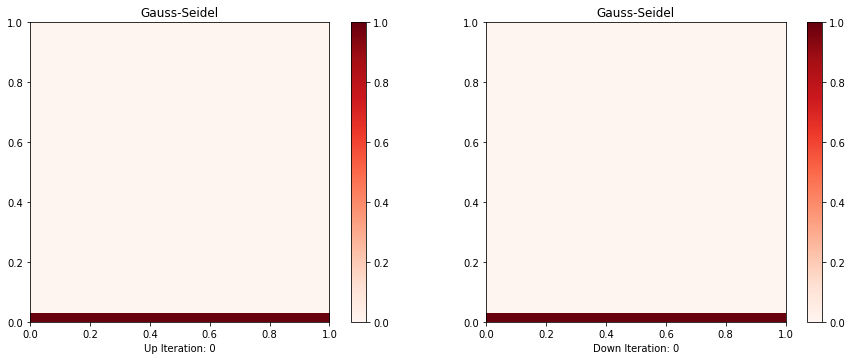

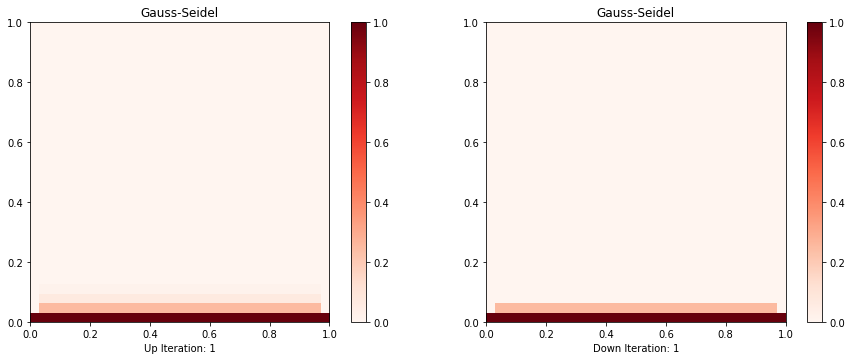

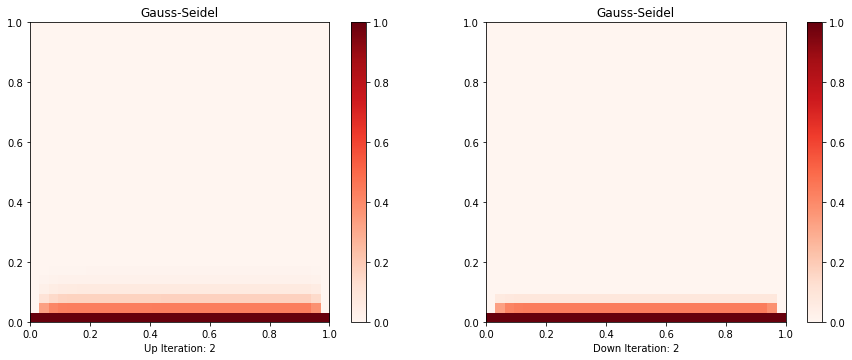

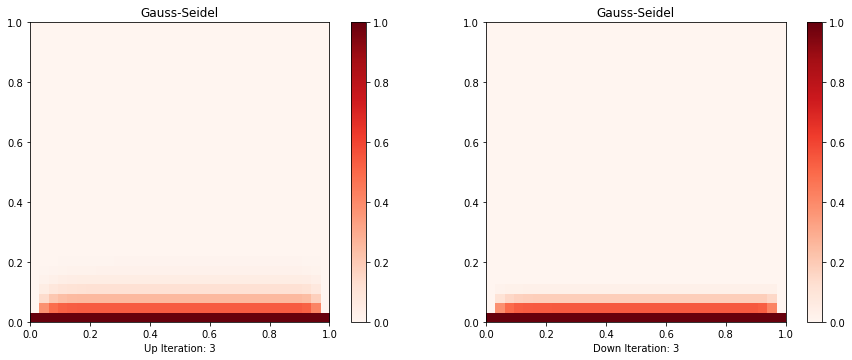

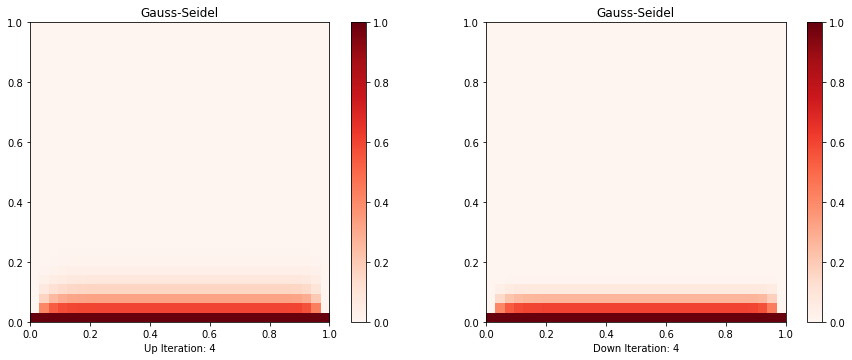

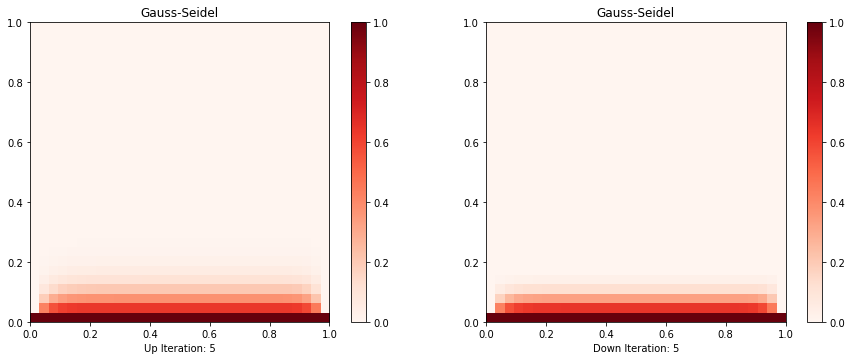

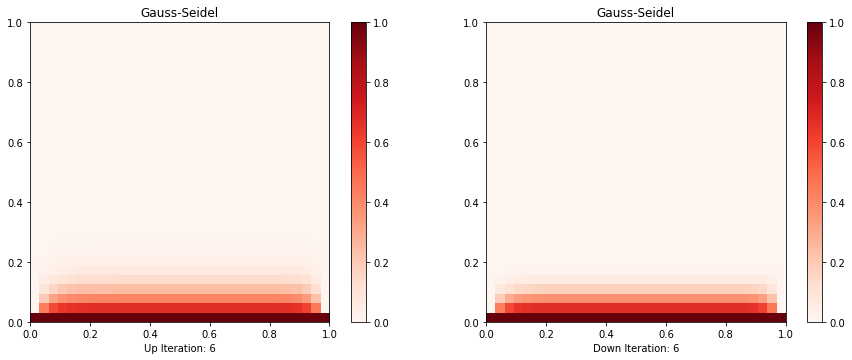

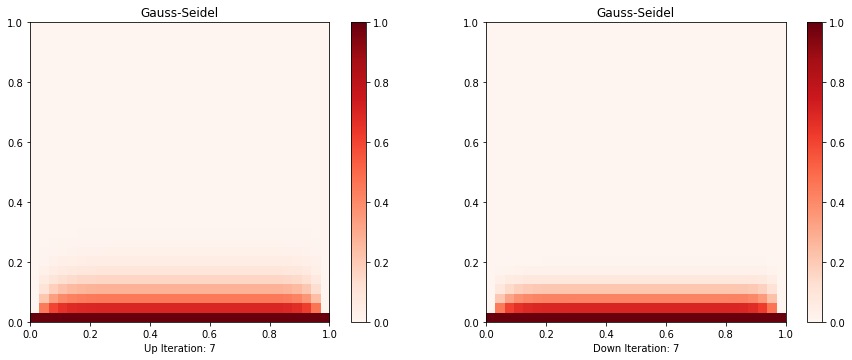

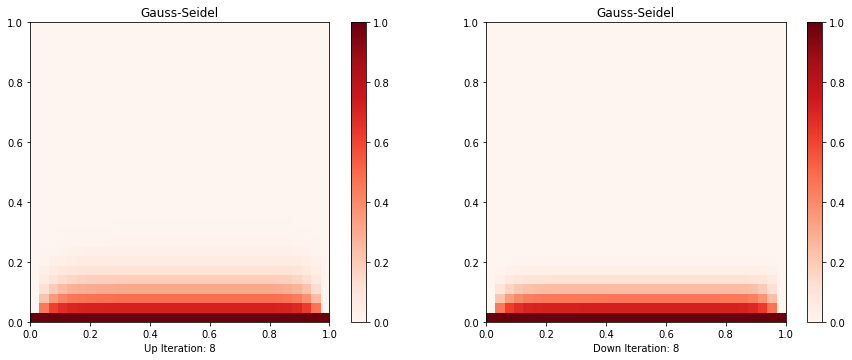

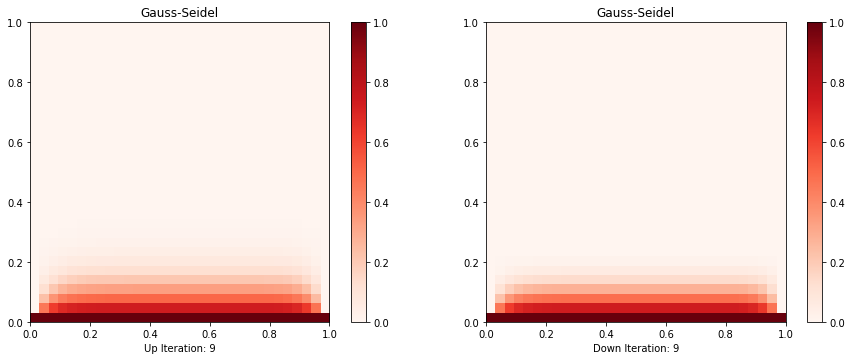

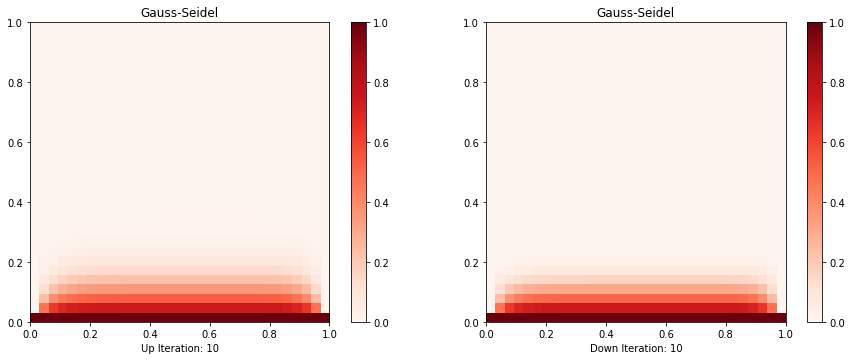

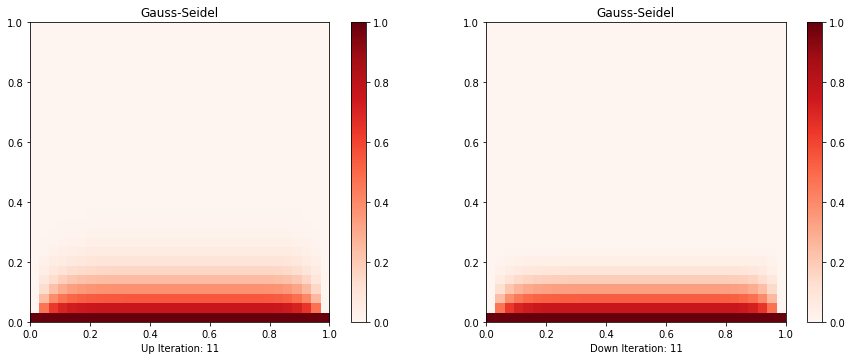

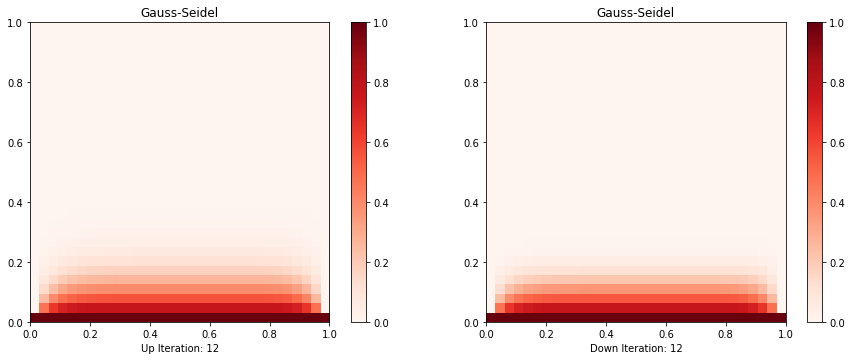

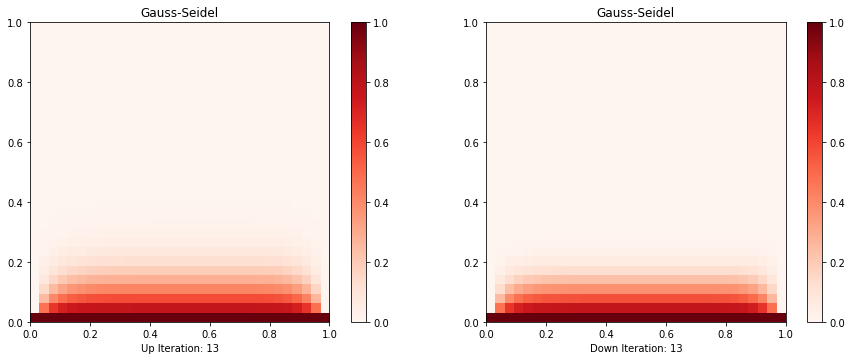

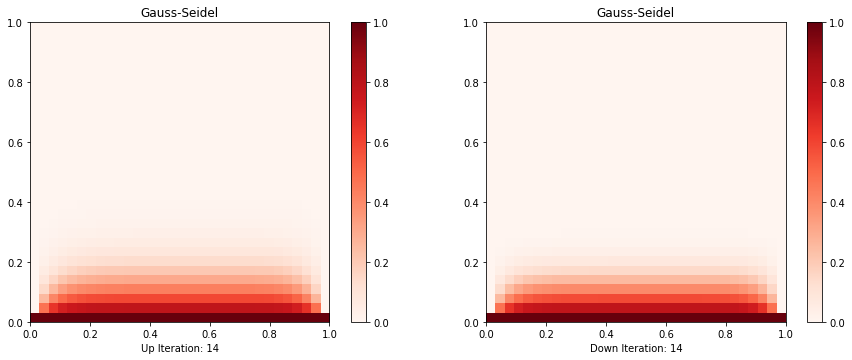

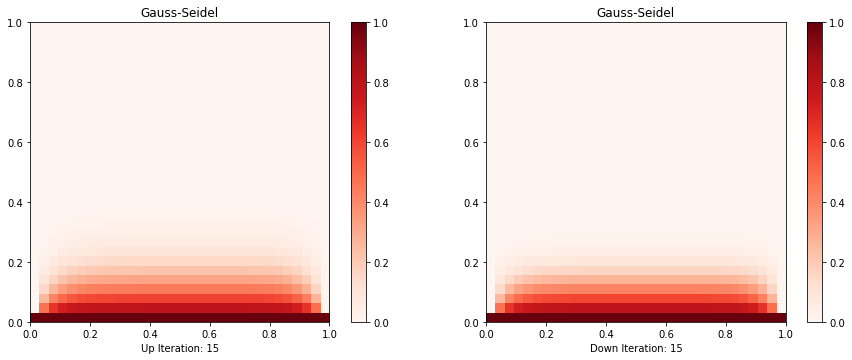

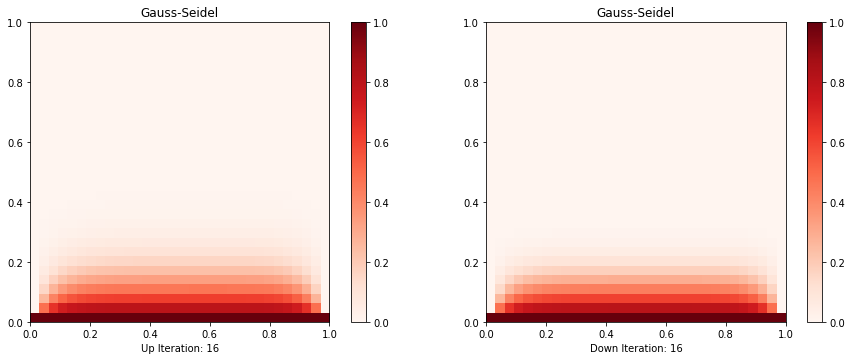

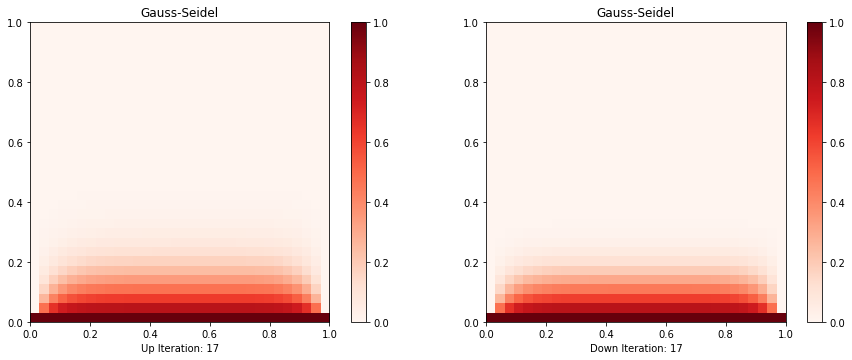

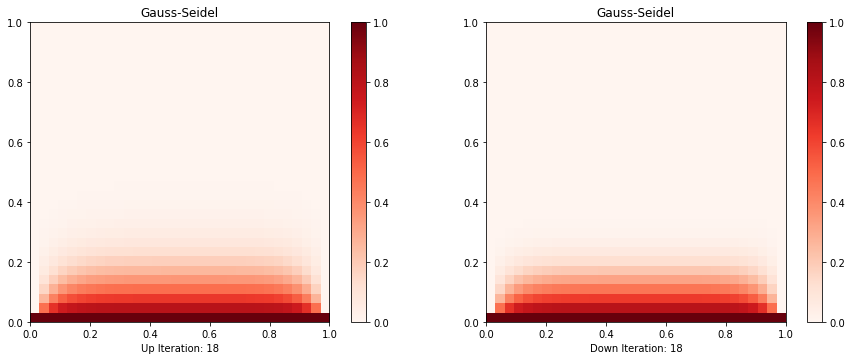

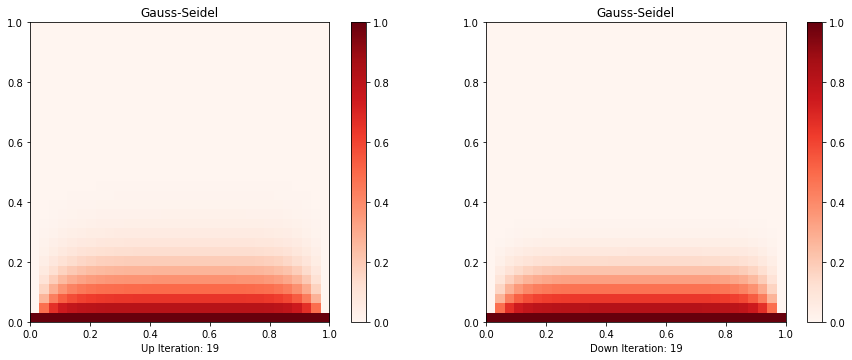

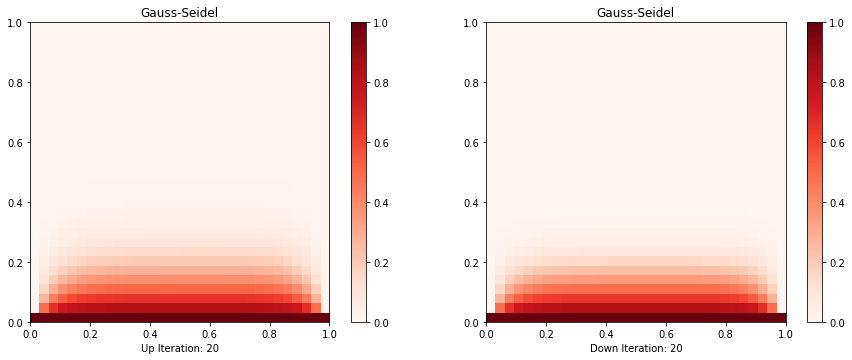

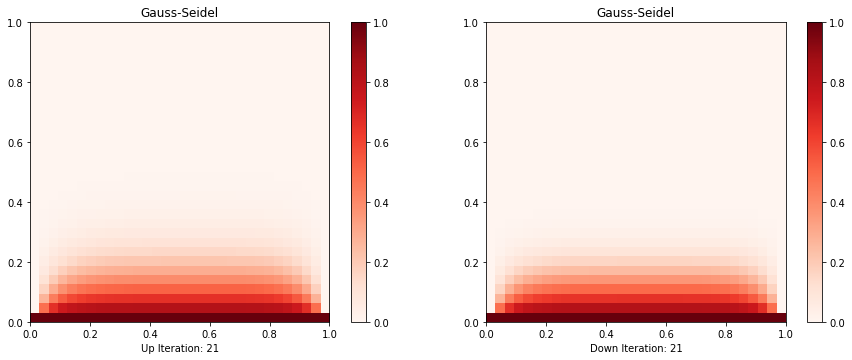

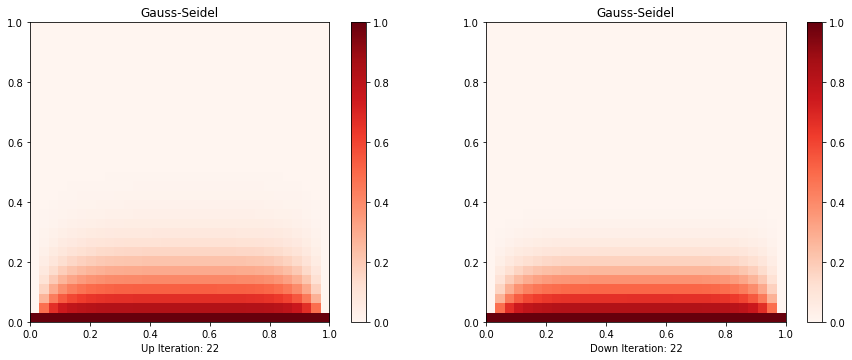

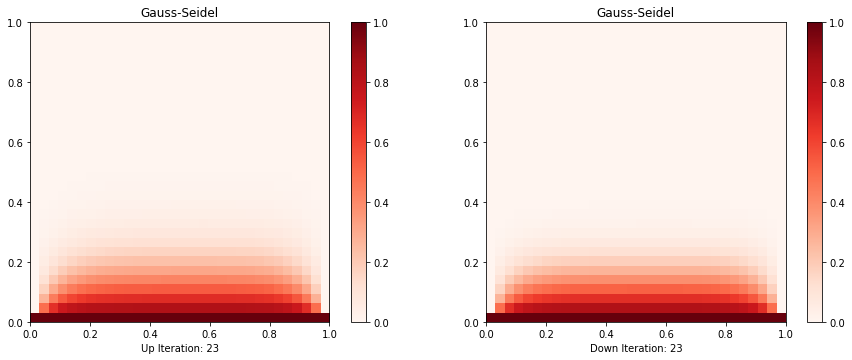

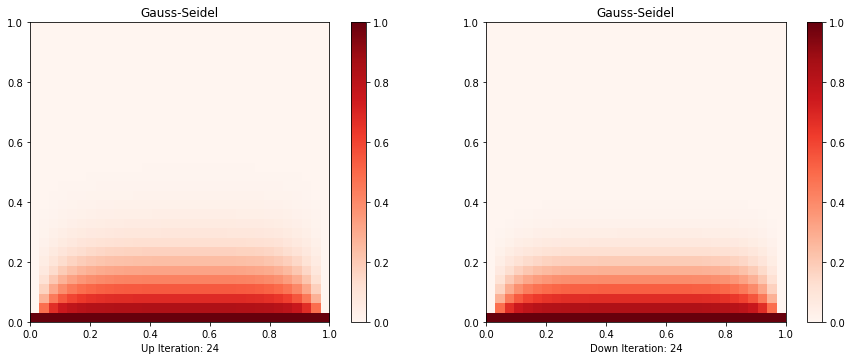

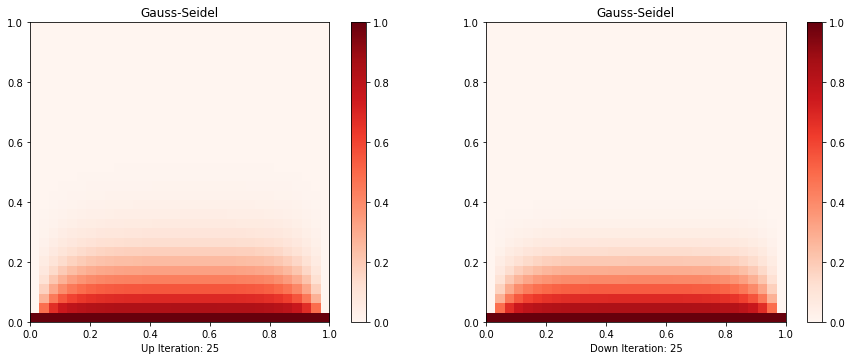

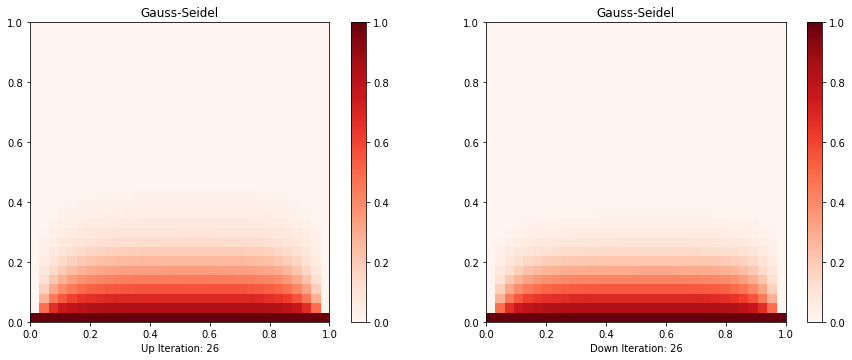

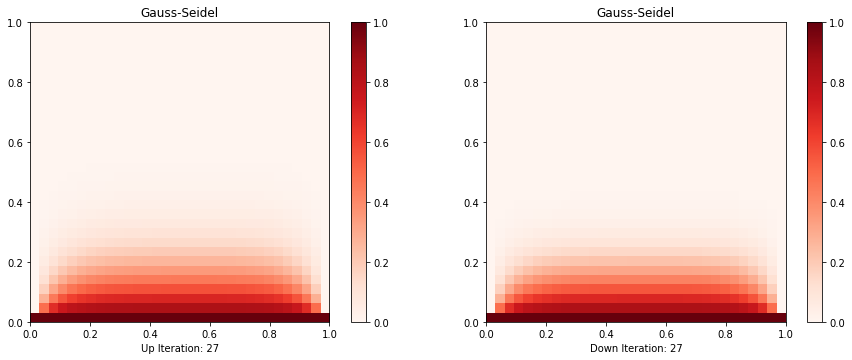

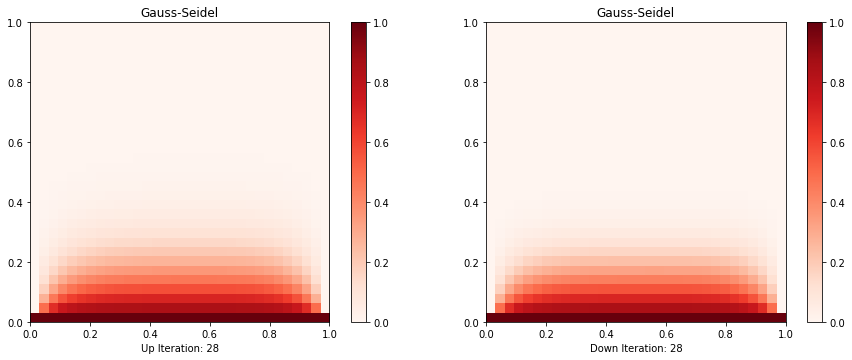

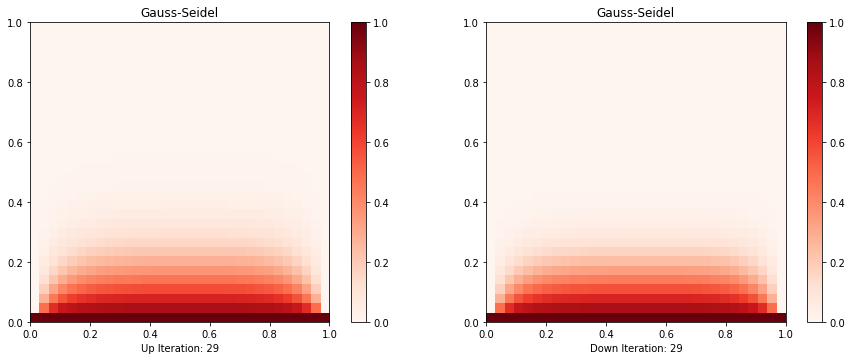

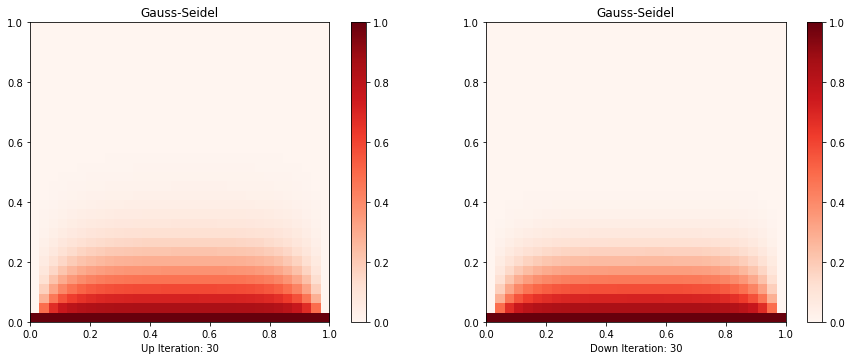

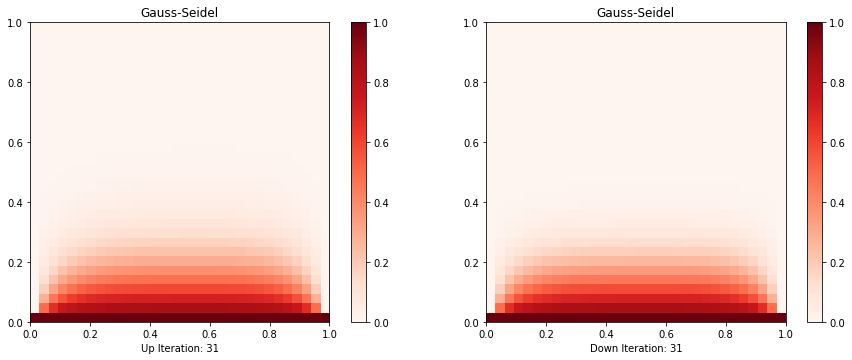

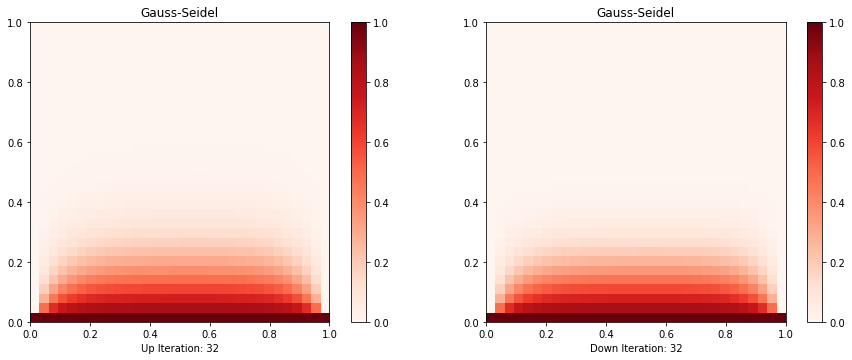

In [11]:
# Repeated calls to gauss_seidel_iteration up and down iterations with the results plotted
# side-by-side for easy comparison.

M = 32

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

u_up = np.copy(u)
v_up = np.copy(u)

u_down = np.copy(u)
v_down = np.copy(u)

plot_side_by_side(v_up, v_down, 'Gauss-Seidel', 0)

for i in range(32):
    gauss_seidel_iteration(M, u_up, v_up, 'up')
    gauss_seidel_iteration(M, u_down, v_down, 'down')
    plot_side_by_side(v_up, v_down, 'Gauss-Seidel', i + 1)
    u_up = v_up
    u_down = v_down

As can been seen from the plots above, Gauss-Seidel iterations in the upwards dierection does indeed transmit information from the bottom to the top boundary faster. But after 32 iterations the difference between the two methods is marginal. This is investigated further in the section below.

## Jacobi and Gauss-Seidel Iteration Convergence Investigation

An investigation was carried out to study the convergence behaviour of Jacobi and Gauss-Seidel
Iteration methods. Two studies were carried out, firstly with a low number of iterations (10), and
secondly with a high number (1024). The results are presented below.

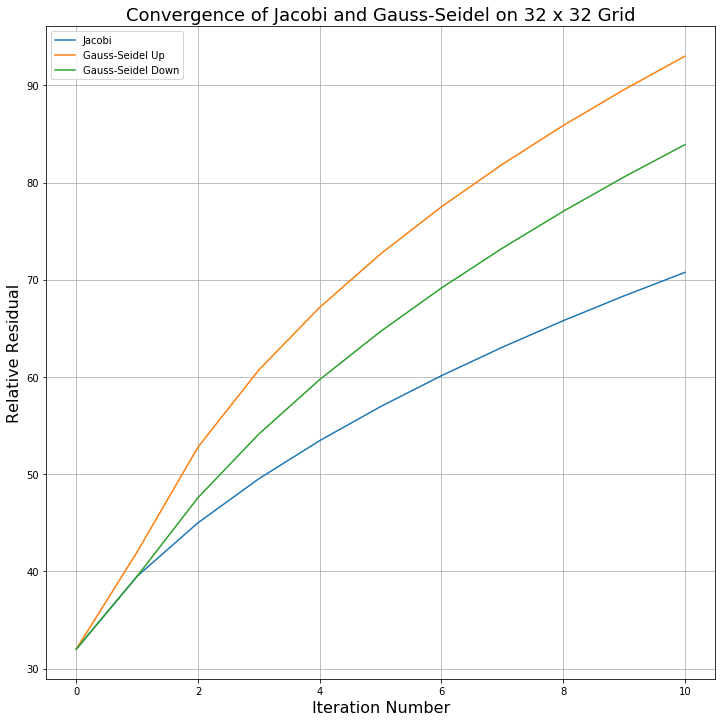

In [12]:
# Investigation into the convergence of Jacobi and Gauss-Seidel Iteration on a unit square
# of 32 x 32 discretisation points.

M = 32

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

u_j = np.copy(u)
u_gs_up = np.copy(u)
u_gs_down = np.copy(u)

v_j = np.copy(u)
v_gs_up = np.copy(u)
v_gs_down = np.copy(u)

laplacian = DiscreteLaplacian(M)

ITERATIONS = 10

data = np.zeros((3, ITERATIONS + 1))

data[0, 0] = np.sum(u_j)
data[1, 0] = np.sum(u_gs_up)
data[2, 0] = np.sum(u_gs_down)

b = np.zeros((M, M), dtype=np.float32)
b[M - 1, :] = 1.0

for i in range(ITERATIONS):
    v_j = laplacian(u_j.flatten()).reshape(M, M)    
    gauss_seidel_iteration(M, u_gs_up, v_gs_up, 'up')
    gauss_seidel_iteration(M, u_gs_down, v_gs_down, 'down')
    data[0, i + 1] = np.sum(v_j)
    data[1, i + 1] = np.sum(v_gs_up)
    data[2, i + 1] = np.sum(v_gs_down)
    u_j = v_j
    u_gs_up = v_gs_up
    u_gs_down = v_gs_down
    
fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(range(ITERATIONS + 1), data[0], label="Jacobi")
plt.plot(range(ITERATIONS + 1), data[1], label="Gauss-Seidel Up")
plt.plot(range(ITERATIONS + 1), data[2], label="Gauss-Seidel Down")

plt.xlabel("Iteration Number", fontsize=16)
plt.ylabel("Relative Residual", fontsize=16)

plt.title("Convergence of Jacobi and Gauss-Seidel on 32 x 32 Grid", fontsize=18)

plt.legend()
plt.grid()
plt.show()

As can be seen from the plot above, at iteration 0, i.e. the initial setup with zero everywhere on the grid except on the bottom boundary, the sum of the discretisation points is 32 (32 x 1 on the bottom boundary). As the iterations start it is immediately apparent that the upwards Gauss-Seidel Iteration method is transmitting information faster than the other two methods.

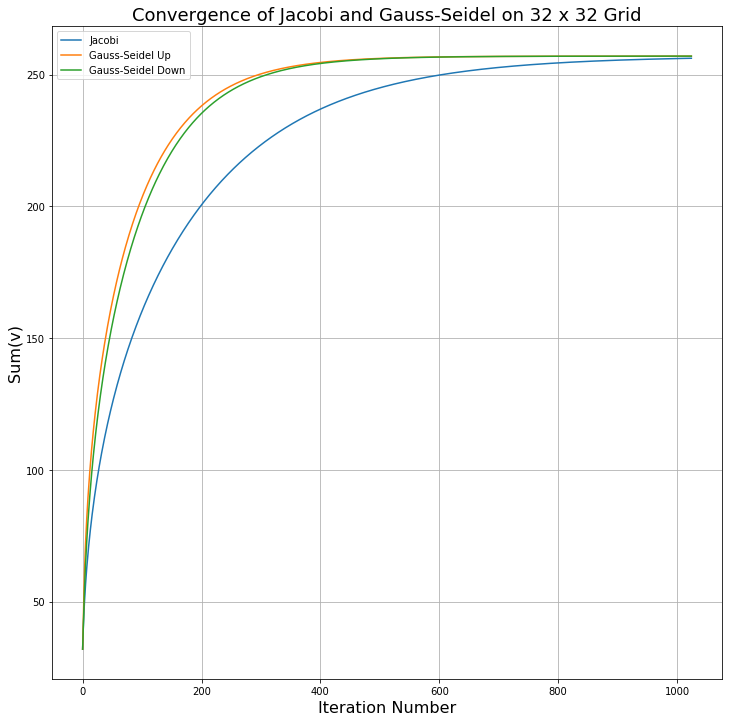

In [13]:
# Investigation into the convergence of Jacobi and Gauss-Seidel Iteration on a unit square
# of 32 x 32 discretisation points.

M = 32

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

u_j = np.copy(u)
u_gs_up = np.copy(u)
u_gs_down = np.copy(u)

v_j = np.copy(u)
v_gs_up = np.copy(u)
v_gs_down = np.copy(u)

laplacian = DiscreteLaplacian(M)

ITERATIONS = 1024

data = np.zeros((3, ITERATIONS + 1))

data[0, 0] = np.sum(u_j)
data[1, 0] = np.sum(u_gs_up)
data[2, 0] = np.sum(u_gs_down)

for i in range(ITERATIONS):
    v_j = laplacian(u_j.flatten()).reshape(M, M)    
    gauss_seidel_iteration(M, u_gs_up, v_gs_up, 'up')
    gauss_seidel_iteration(M, u_gs_down, v_gs_down, 'down')
    data[0, i + 1] = np.sum(v_j)
    data[1, i + 1] = np.sum(v_gs_up)
    data[2, i + 1] = np.sum(v_gs_down)
    u_j = v_j
    u_gs_up = v_gs_up
    u_gs_down = v_gs_down
    
fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(range(ITERATIONS + 1), data[0], label="Jacobi")
plt.plot(range(ITERATIONS + 1), data[1], label="Gauss-Seidel Up")
plt.plot(range(ITERATIONS + 1), data[2], label="Gauss-Seidel Down")

plt.xlabel("Iteration Number", fontsize=16)
plt.ylabel("Sum(v)", fontsize=16)

plt.title("Convergence of Jacobi and Gauss-Seidel on 32 x 32 Grid", fontsize=18)

plt.legend()
plt.grid()
plt.show()

As can be seen from the plot above after a larger number of iterations all three methods converge towards a bounding value. However, both Gauss-Seidel methods converge towards this value significantly faster than Jacob, with Gauss-Seidel upwards being the fastest. This result is to be expected from the previous numerical correctness testing, where it was observed that the upwards Gauss-Seidel method was observed to transmit information from the bottom to top boundary in a single iteration. 

## Gauss-Seidel Iteration - Relaxed OpenCL Implementation

In [14]:
# Define the OpenCL kernel string used in the class GaussSeidelUpUpdateRow. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void gauss_seidel_up_update_row(const int m, __global const float *u, __global float *v)
{
    // Retrieve the row and column indexes from the global id's.
    
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // This kernel receives a global workspace of 3 rows of length m.
    
    // We are only interested in updating row 1. So, don't change rows 0 or 2,
    // or change the end boundary conditions of row 1.
    
    if (r == 0 || r == 2 || c == 0 || c == m - 1) {
        v[m * r + c] = u[m * r + c];
        return;
    }
    
    // Implement the averaging formula for the interior points of row 1.
    
    v[m * r + c] = (u[m * (r + 1) + c] + u[m * (r - 1) + c] + u[m * r + (c + 1)] + u[m * r + (c - 1)]) / 4.0f;
}

"""


# Define the class GaussSeidelUpUpdateRow.

class GaussSeidelUpUpdateRow():
    
    def __init__(self, m):
        
        # Store the size m as an instance variable for access by class methods.
        
        self._m = m
        
        self.dytpe = np.float32
        

        # Create a GPU specific context and command queue.
        
        self._ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self._queue = cl.CommandQueue(self._ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 

        # Create input and output buffers, u and v. Note: u is READ_ONLY and v is WRITE_ONLY.
 
        self._u = cl.Buffer(self._ctx, cl.mem_flags.READ_ONLY, size = np.dtype(np.float32).itemsize * 3 * m)
        
        self._v = cl.Buffer(self._ctx, cl.mem_flags.WRITE_ONLY, size = np.dtype(np.float32).itemsize * 3 * m)
        

        # Build the kernel.
        
        self._kernel = cl.Program(self._ctx, kernel_string).build().gauss_seidel_up_update_row

    
    def do(self, u):

        # Use mapped input to efficiently copy the input vector u to the device.
        
        mapped_input, _ = cl.enqueue_map_buffer(self._queue, self._u, cl.map_flags.WRITE, 0, 3 * self._m, np.float32)
        
        with mapped_input.base:
            mapped_input[:] = u.astype(np.float32)


        # Run the kernel across all grid points in parallel using a global workspace 3 x m. 
            
        self._kernel(self._queue, (3, self._m), None, np.int32(self._m), self._u, self._v)


        # Create an output vector v and copy the output from the device.
                     
        v = np.zeros((3, self._m), dtype=np.float32)

        cl.enqueue_copy(self._queue, v, self._v)
                     

        # Return v as the correct datatype.
            
        return v.astype(np.float32)

In [15]:
def gauss_seidel_iteration_opencl(m, v, direction='up'):
    """
    This function funtion implements an 'up' or 'down' Gauss-Seidel iteration of the input/output
    vector v. A single vector is used because both "old" and "new" data is required to update
    each row, so this is done in-place in a single vector.
    """
    up_update_row = GaussSeidelUpUpdateRow(m)
    
    if (direction == 'up'):
        for i in range(m - 2, 0, -1):
            v[i - 1 : i + 2, :] = up_update_row.do(v[i - 1 : i + 2, :].flatten()).reshape(3, m)

    if (direction == 'down'):
        for i in range(1, m - 1):
            v[i - 1 : i + 2, :] = up_update_row.do(v[i - 1 : i + 2, :].flatten()).reshape(3, m)

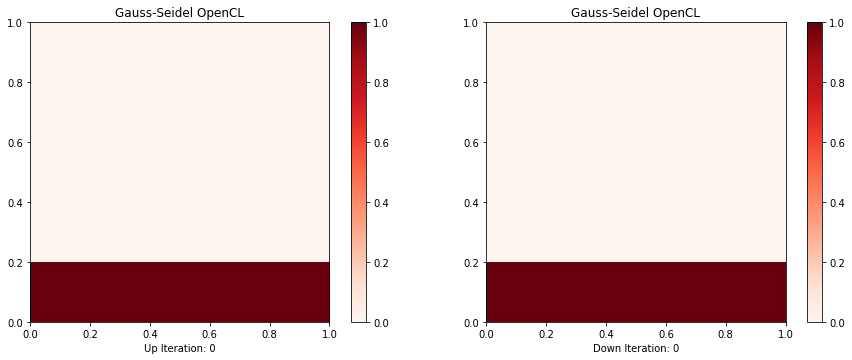

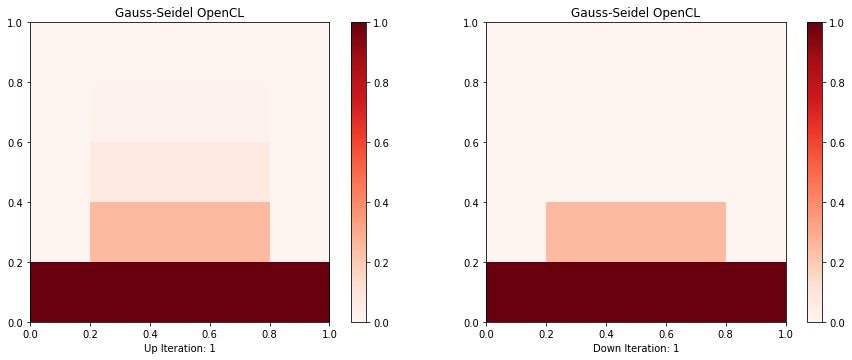

In [16]:
M = 5

# Create a test input vector u setting the boundary conditions.

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

# Create the output vectors v_up and v_down.

v_up = np.copy(u)
v_down = np.copy(u)

# Plot v_up and v_down prior to calling gauss_iteration().

plot_side_by_side(v_up, v_down, 'Gauss-Seidel OpenCL', 0)

# Call the Gauss-Seidel iteration function both up and down.

gauss_seidel_iteration_opencl(M, v_up, 'up')
gauss_seidel_iteration_opencl(M, v_down, 'down')

# Plot the results.

plot_side_by_side(v_up, v_down, 'Gauss-Seidel OpenCL', 1)

As can be seen in the plot above, using OpenCL to parallise the updating of row elements results in the same transmission of data from the lower to upper boundary as previously seen. The Gauss-Seidel upwards iteration transmit information from bottom to top in a single iteration.

## Gauss-Seidel Iteration and Gauss-Seidel Relaxed OpenCL Convergence Investigation

An investigation was carried out to investigate the convergence of Gauss-Seidel Iteration and Gauss-Seidel Relaxed OpenCL Iteration methods. The results are presented in the plot below.

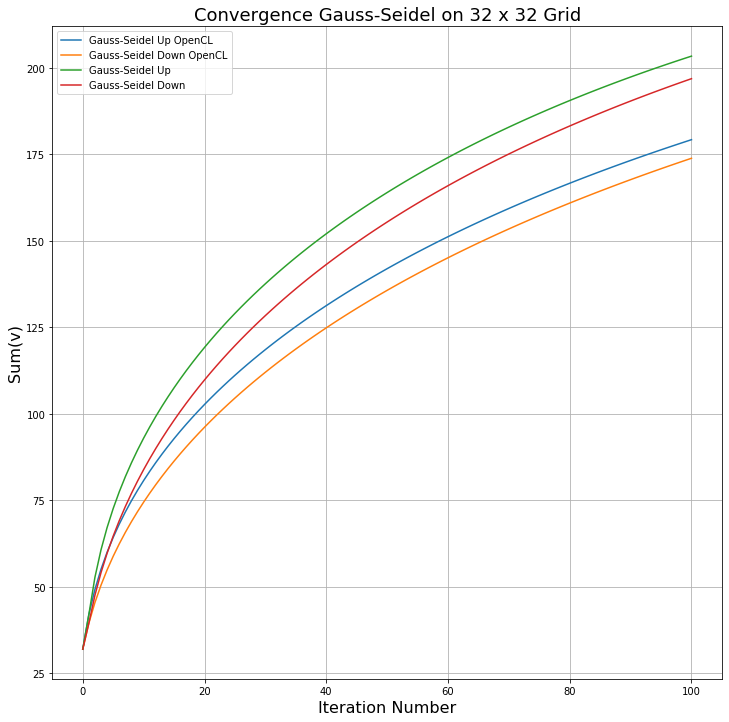

In [17]:
# Investigation into the convergence of Gauss-Seidel Iteration on a unit square
# of 32 x 32 discretisation points.

M = 32

u = np.full((M, M), 0.0, dtype=np.float32)

u[:, 0] = 0.0
u[0, :] = 0.0
u[:, M-1] = 0.0
u[M-1, :] = 1.0

u_gs_cl_up = np.copy(u)
u_gs_cl_down = np.copy(u)
u_gs_up = np.copy(u)
u_gs_down = np.copy(u)

v_gs_cl_up = np.copy(u)
v_gs_cl_down = np.copy(u)
v_gs_up = np.copy(u)
v_gs_down = np.copy(u)

ITERATIONS = 100

data = np.zeros((4, ITERATIONS + 1))

data[0, 0] = np.sum(u_gs_cl_up)
data[1, 0] = np.sum(u_gs_cl_down)
data[2, 0] = np.sum(u_gs_up)
data[3, 0] = np.sum(u_gs_down)

for i in range(ITERATIONS):
    gauss_seidel_iteration_opencl(M, v_gs_cl_up, 'up') # Iterations done in-place.
    gauss_seidel_iteration_opencl(M, v_gs_cl_down, 'down') # Iterations done in-place.
    gauss_seidel_iteration(M, u_gs_up, v_gs_up, 'up')
    gauss_seidel_iteration(M, u_gs_down, v_gs_down, 'down')
    data[0, i + 1] = np.sum(v_gs_cl_up)
    data[1, i + 1] = np.sum(v_gs_cl_down)
    data[2, i + 1] = np.sum(v_gs_up)
    data[3, i + 1] = np.sum(v_gs_down)
    u_gs_up = v_gs_up
    u_gs_down = v_gs_down
    
fig = plt.figure(figsize=(12.0, 12.0))

plt.plot(range(ITERATIONS + 1), data[0], label="Gauss-Seidel Up OpenCL")
plt.plot(range(ITERATIONS + 1), data[1], label="Gauss-Seidel Down OpenCL")
plt.plot(range(ITERATIONS + 1), data[2], label="Gauss-Seidel Up")
plt.plot(range(ITERATIONS + 1), data[3], label="Gauss-Seidel Down")

plt.xlabel("Iteration Number", fontsize=16)
plt.ylabel("Sum(v)", fontsize=16)

plt.title("Convergence Gauss-Seidel on 32 x 32 Grid", fontsize=18)

plt.legend()
plt.grid()
plt.show()

As can be seen from the plot above the Gauss-Seidel Relaxed OpenCL Iteration method convergences towards a bounding value at a slower rate that the Numba implementation of Gauss-Seidel Iteration method for both the upwards and downwards directions. But for each method the upwards method transmits information more quickly than the downwards method. This is to be expected from the study of previous results.

The reason the Gauss-Seidel Relaxed OpenCL method transmits information more slowly than the standard method is likely to be because the neighbouring points in each row are not updated sequentially. They are updated in an unpredictable parallel order. The result of this is that the neighbouring points to the left and right of each point may, or may not have, already been updated when the current point is being updated updated. This differs from the standard method, when, say, if the row is processed for left to right, then the point to the left is guaranteed to be in an updated state and be of a higher value due to the transmittion of information. 

# Question 2: Preconditioned Iterative Solvers

I initially attempted to answer this question by splitting the L domain into 3 separate smaller square domains. However, I abandoned this work because this approach didn't seem to match the problem domain sufficiently closely, and introduced boundary matching problems which seemed overly complicated. I have included my intial work on this attempt at the bottom of the notebook for completeness. **Please do not mark this initial work at the bottom of this notebook.**

## Program Description

After abandoning my first attempt to answer this question, I decided to view the L shape as a single square domain with a quarter square removed in the lower right corner. This is how I have answered this question.

My justification for viewing the problem as a single domain is that the interior points of the L shape are not affected by the points in the lower right quarter. The stencil only uses points on the L shape boundary and neighbouring interior points, so the lower right quarter can effectively be ignored and then removed from the solution. This is the approach I have taken, which seems a more natural fit to the problem domain and also removes the boundary matching issues mentioned above.

So, as requested by the question, I have written a function stencil_discretisation() which takes single parameter 'h', the grid spacing, and returns 'n', the number of points on the grid, the stencil operator matrix 'A', and the right hand side 'b'. Returning 'n' was not asked for in the question but this seems an obvious and convenient thing to do.

The matrix 'A' is the stencil operator which operates on the L domain, and the right hand side vector 'b' contains the boundary conditions. Using the SciPy cg iterative solver, an initial guess 'u' is iterated to the solution 'x'. As can been seen below, the solution 'x' does indeed satisfy Ax = b.

The generation of matrix 'A' requires some further explanation.

The 'A' matrix applies the stencil operator. But my implementation of this does not apply the stencil operator uniformly, it is selective in where the stencil is applied. In this question it applies the stencil to the two top quarters and the bottom left of the quarter of the L domain. For the bottom right quarter is acts as the Identity matrix.

To achieve this selectivity in application of the stencil operator, within the stencil_discretisation() function each row of the 'A' matrix is considered in turn. Each row can be considered as a "recipe" for contructing each element of the solution vector. When considering each row, we decide which element of the solution vector we are looking at, and then build the stencil around the Identity element of this row, i.e. around the row element j = i. How this is done is described in further detail in the stencil_discretisation() function code. 

## Program Structure

As stated above, the program is implemented as a function stencil_discretisation(). This function takes a single parameter 'h' which is the desired grid spacing. The functionand returns 'n', the number of points on the grid, the stencil operator matrix 'A', and the right hand side 'b'. Returning 'n' was not asked for in the question but this seems an obvious and convenient thing to do.

Within the function stencil_discretisation() the boundary conditions are set using the function:

    f[x, y] = 0.5 * np.log((x - (2 * n))**2 + (y - (2 * n))**2)

The (x0, y0) is selected to be the bottom right corner of the domain.

The 'A' matrix, together with the vector 'b', and an initial guess vector 'u' are passed to the SciPy cg iterative solver to generate the solution 'x' to the system.

## Visualisation

To provide good visualisation we first plot the matrix A and vector b as produced by the stencil_discretisatio() operator. 

We then use the 'callback' parameter of the SciPy cg iterative operator to plot the solution at each iteration for a suitable number of illustrative iteration steps.

We then plot the solution as produced by the SciPy cg iterative solver. It is clear that the stencil_discretisation() operator is recreating the test function defined as boundary conditions within the interior of the L domain.

Note, the function plot_x(), which is called as the cg callback function, uses a mask of ones and numpy.nan values to prevent plotting of the lower right hand quarter.

## Convergence of CG with Increased Discretisation Points

A study was conducted to investigate the convergence of CG with increased discretisation points. The results of this study are plotted and presented in the relevant section below.

## Incomplete LU Factorisation (ILU) and CG Convergence

An investigation was carried out into the effect of drop tolerance in ILU factorisation on CG convergence. The results of this study are also plotted and presented in the relevant section below.

In [18]:
# Declare the function stencil_discretisation().

def stencil_discretisation(h):
    """
    This function takes a single parameter 'h' which is the required grid spacing over a domain
    [-1, 1], [-1, 1]. This parameter is then used to calculate 'n' which is number of grid points
    in the interval the [0, 1]. Hence, the domain of this problem is (2 * n) x (2 * n). The
    funhction then generates matrix 'A' and vector 'b'. The function returns 'n', 'A' and 'b'. 
    The matrix 'A' is created in COO format before being returned in CSR format.
    """

    # Derive n from h.
    
    n = np.int32(1.0 / h + 1)
    
    
    # Declare a convenience variable m. Note, the overall size of the L shape is (2 * n) x (2 * n).

    m = (2 * n) * (2 * n) 
    
    
    # Create an empty COO matrix A.

    A = coo_matrix((m, m), dtype=np.float64)
    

    # Set the matrix A to the Identity matrix. This is the default value for the matrix 'A' and
    # ensure 'A' is a diagonal and symmetric matrix to use in the SciPy cg iterative solver. 
    
    A.setdiag(1.0)


    # Loop over each row in matrix 'A'. Each row is a "recipe" for generating the corresponding
    # element of the solution vector. We need to create this recipe.

    for i in range(m):

        # The "recipe" is created around the Identity value of the matrix 'A'. So, we are only
        # interested in the (i, j) element to create our "recipe".
        
        j = i

        # The next line requires some explanation. Each row of the matrix contains
        # (2 * n) * (2 * n) elements, with each row corresponding to a single value
        # in the solution vector which is of length (2 * n). So, we use 'i' to determine
        # which part of the L domain we are in. Having done this, if we do an integer
        # division of the row index 'i' by the length of one side of our domain (2 * n)
        # we can use the remainder to detemine the central point around which to create
        # our "recipe".
        
        remainder = i % (2 * n)
        
        # Are we in the 2 top quarters of the L domain?

        if (i > (2 * n) and i < (n - 1) * (2 * n)):
            
            # If so, the remainder tells us the central point to create our "recipe" around.
            # In this case between each of the two boundaries at 0 and (2 * n) - 1.

            if (remainder > 0 and remainder < (2 * n) - 1):
                
                # Create the stencil "recipe".
            
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j)
                A.data = np.append(A.data, 3.0)  # The Identity already added 1 to the COO matrix.       

                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j - 1)
                A.data = np.append(A.data, -1.0)        

                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j + 1)
                A.data = np.append(A.data, -1.0)
            
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j - (2 * n))
                A.data = np.append(A.data, -1.0)        

                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j + (2 * n))
                A.data = np.append(A.data, -1.0)
            

        # Are we in the bottom left quarter of the L domain?
            
        if (i > (n - 1) * (2 * n) and i < (2 * n) * (2 * n) - (2 * n)):

            # If so, the remainder tells us the central point to create our "recipe" around.
            # In this case between each of the two boundaries at 0 and (n - 1).

            if (remainder > 0 and remainder < n - 1):
            
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j)
                A.data = np.append(A.data, 3.0)  # The Identity already added 1 to the COO matrix.       

                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j - 1)
                A.data = np.append(A.data, -1.0)        

                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j + 1)
                A.data = np.append(A.data, -1.0)
            
                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j - (2 * n))
                A.data = np.append(A.data, -1.0)        

                A.row = np.append(A.row, i)
                A.col = np.append(A.col, j + (2 * n))
                A.data = np.append(A.data, -1.0)

                
    # Set the boundary conditions in b to f(x, y) = 0.5 * log((x - x0)**2 +(y - y0)**2),
    # where (x0, y0) is (2 * n, 2 * n).
    
    b = np.zeros((2 * n, 2 * n), dtype=np.float64)
    
    for x in range(2 * n):
        for y in range(2 * n):
            b[x, y] = 0.5 * np.log((x - (2 * n))**2 + (y - (2 * n))**2)
    b[1 : n - 1, 1 : 2 * n - 1] = 0
    b[n -1 : 2 * n - 1, 1 : n - 1] = 0


    # Return n, the matrix A in CSR format, and b as a vector.
    
    return n, A.tocsr(), b.flatten()

## Visualisation

In [19]:
# Declare a function to plot the solution. Note the use of an ndarray of ones and np.nan to
# mask the bottom right area.

def plot_x(x):
    plt_mask = np.ones(((2 * n), (2 * n)), dtype=np.float64)
    plt_mask[n : (2 * n), n : (2 * n)] = np.nan
    plt.figure(figsize=(10, 8.0))
    plt.imshow(x.reshape((2 * n), (2 * n)) + plt_mask)
    plt.axis('Off')
    plt.show()

### Visualisation of Matrix A and Vector b

Below are the plots of Matrix A and vector b as produced by calling stencil_discretisation(). Note that although, as previously stated, the A matrix is not uniform in the operation it applies, it is diagonal and symmetric as required by the SciPy cg iterative solver.

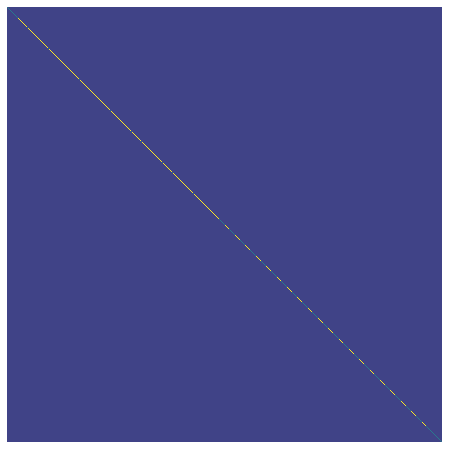

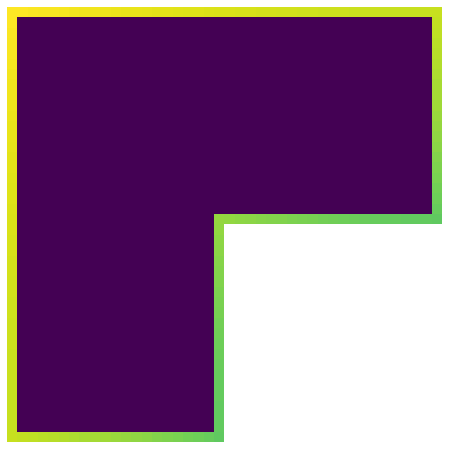

In [20]:
# Use the SciPy cg iterative solver to solve the system and generate iteration plots.

n, A, b = stencil_discretisation(0.05)

# Plot 'A'

plt.figure(figsize=(10, 8.0))
plt.imshow(A.todense())
plt.axis('Off')
plt.show()

# Plot 'b'

plot_x(b.reshape(2 * n, 2 * n))

### Visualisation of the Iterations to the Solution

Below is plotted a series of iterative solutions to the system as produced by the SciPy cg iterative solver.

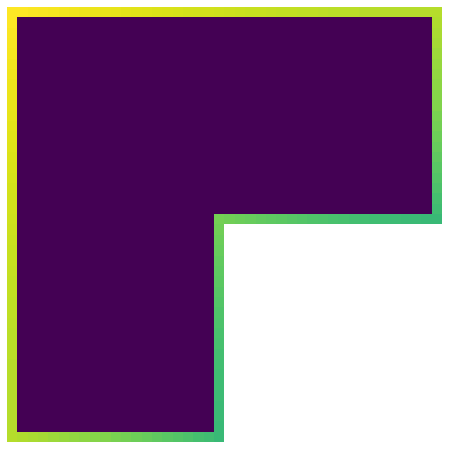

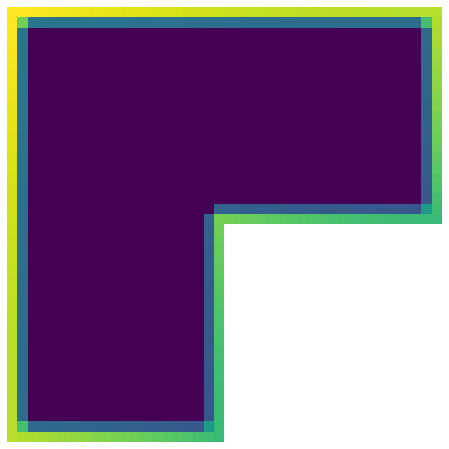

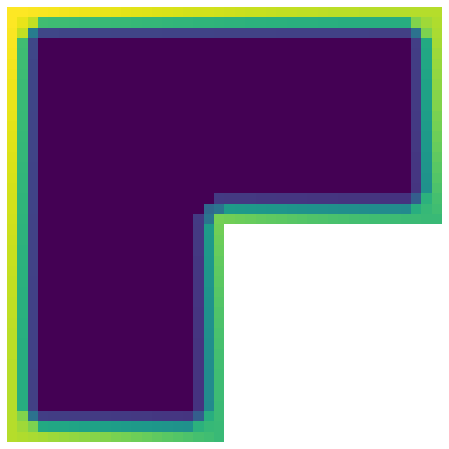

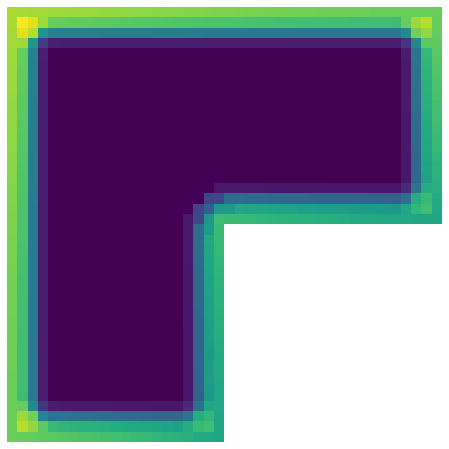

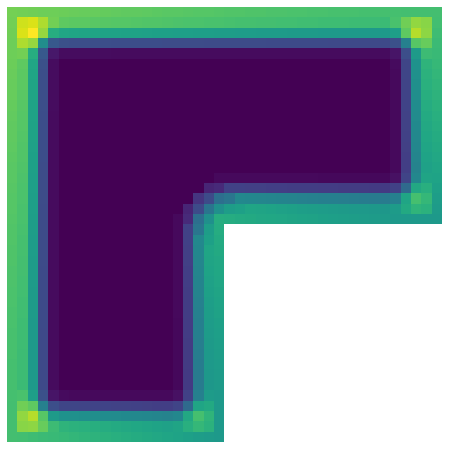

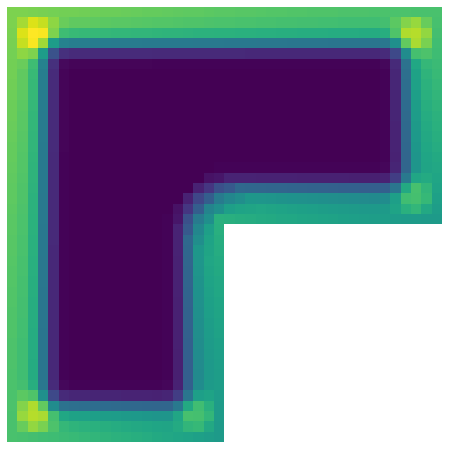

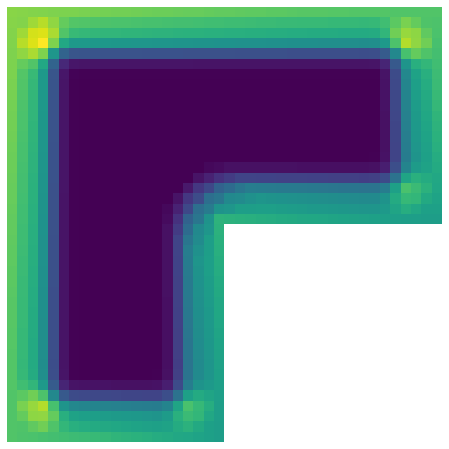

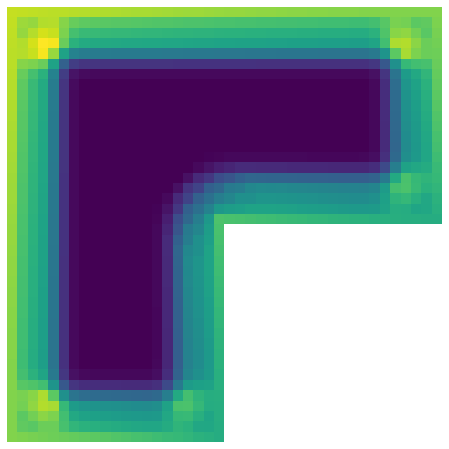

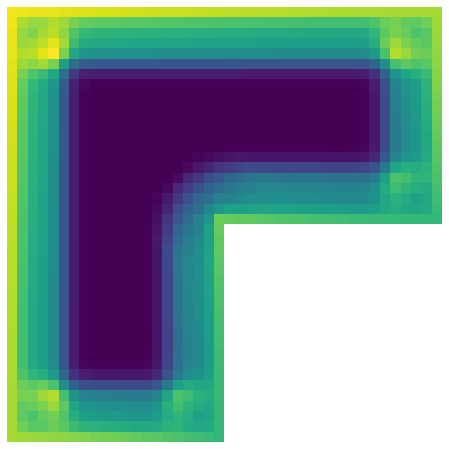

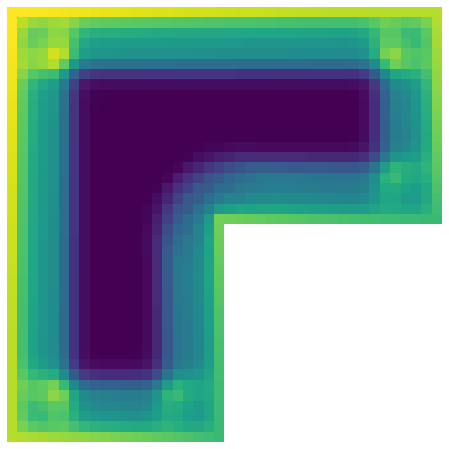

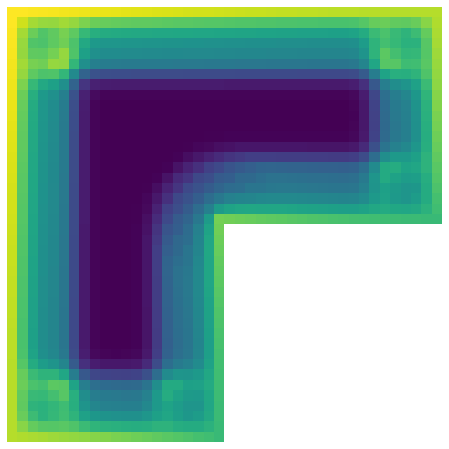

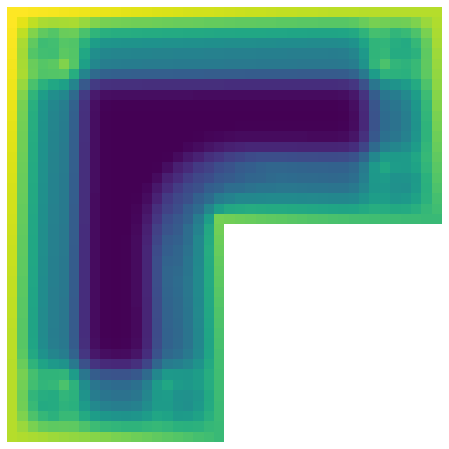

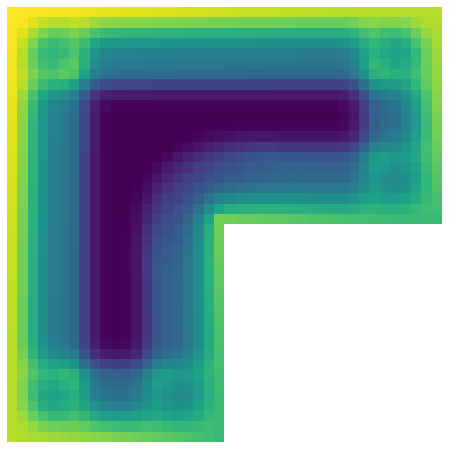

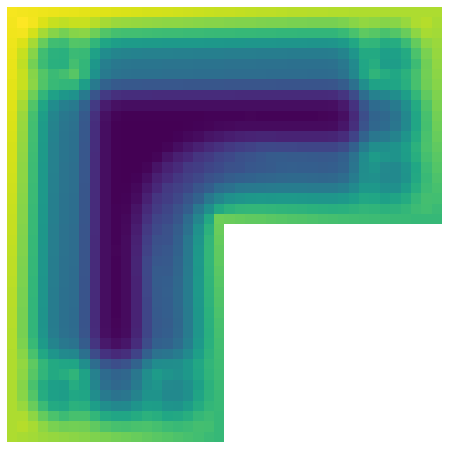

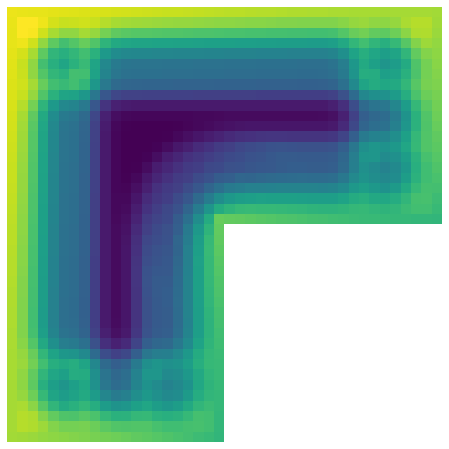

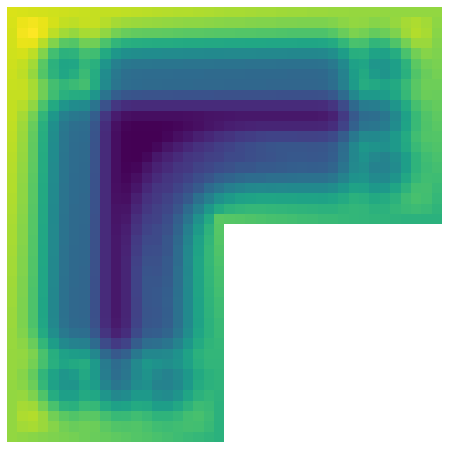

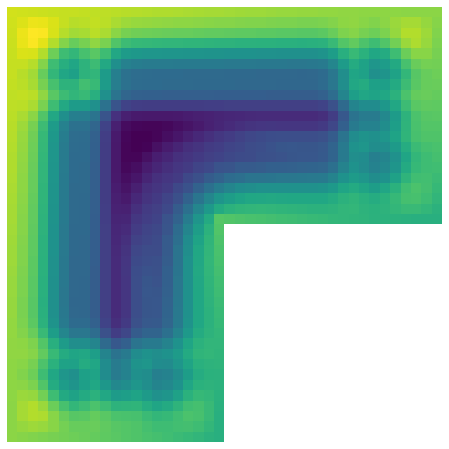

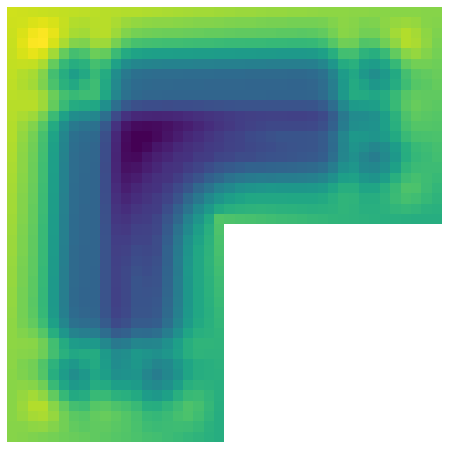

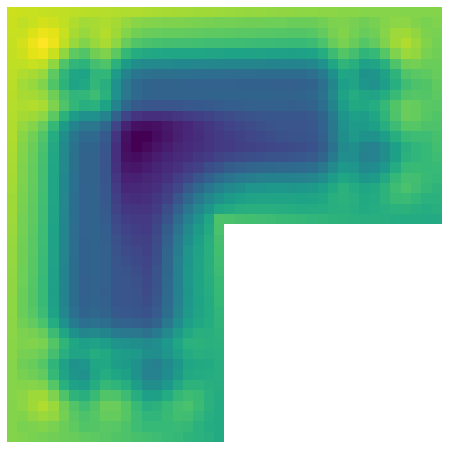

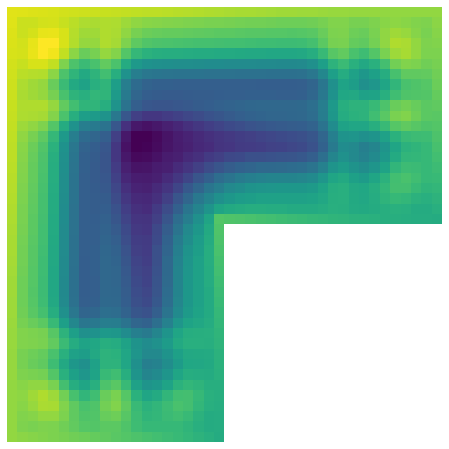

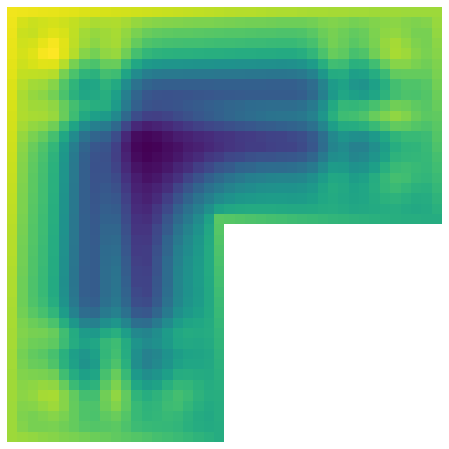

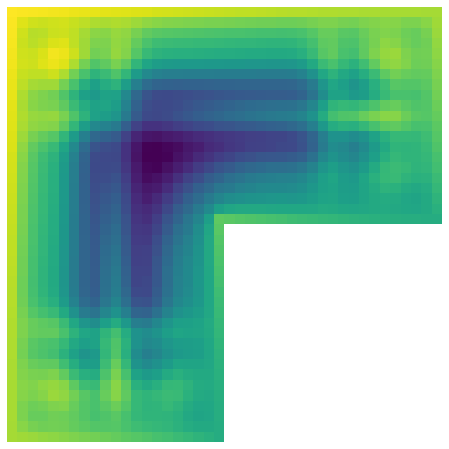

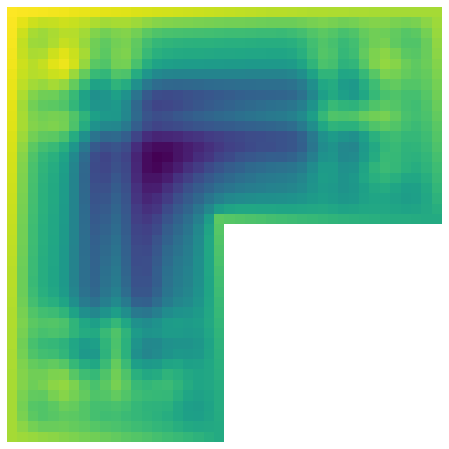

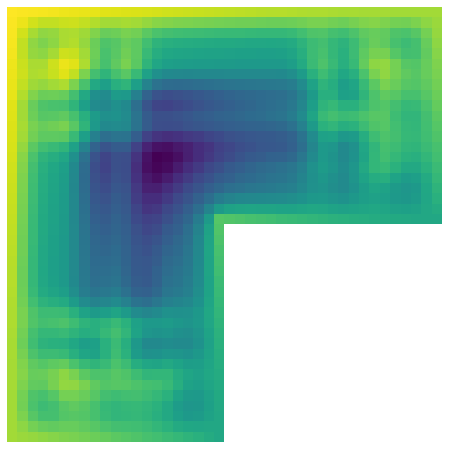

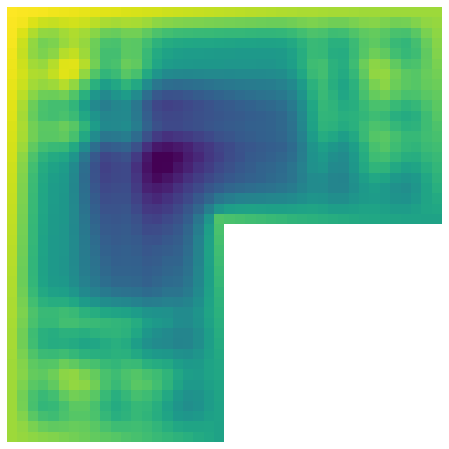

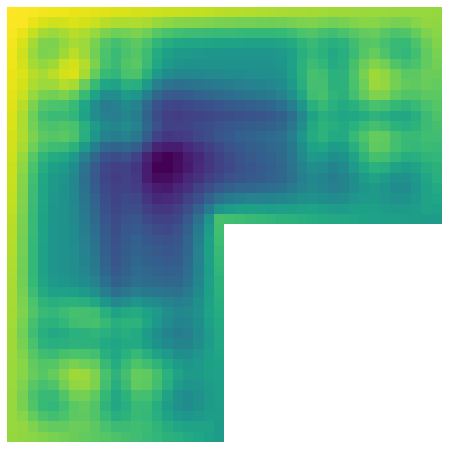

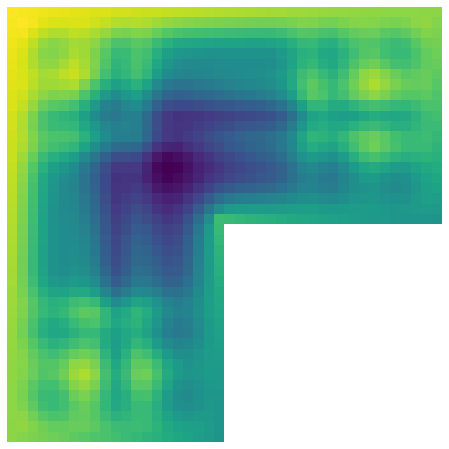

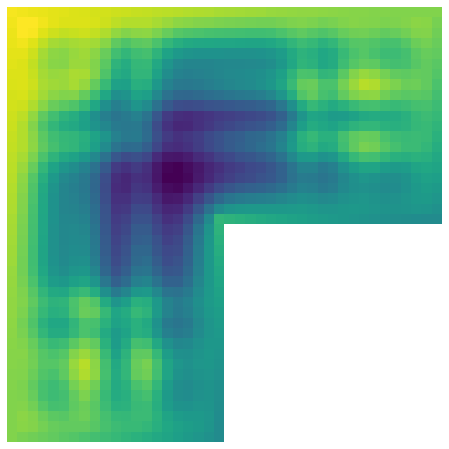

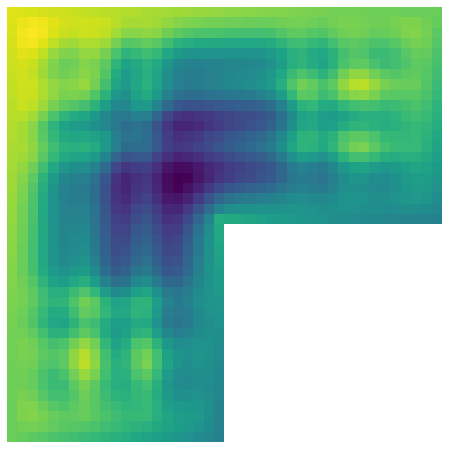

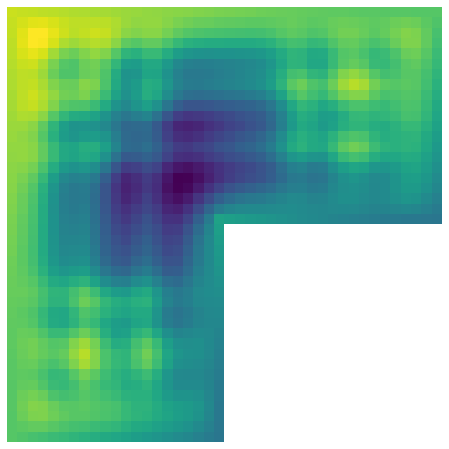

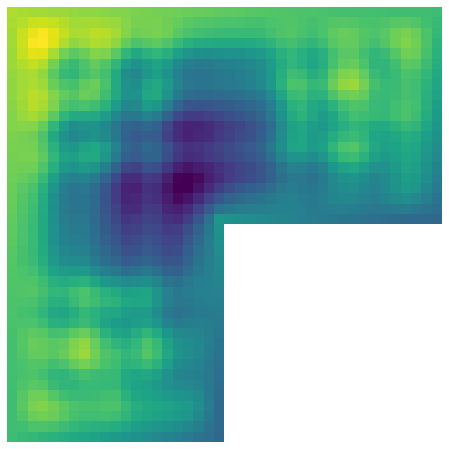

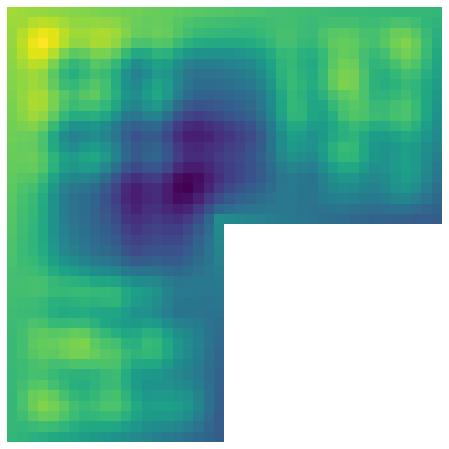

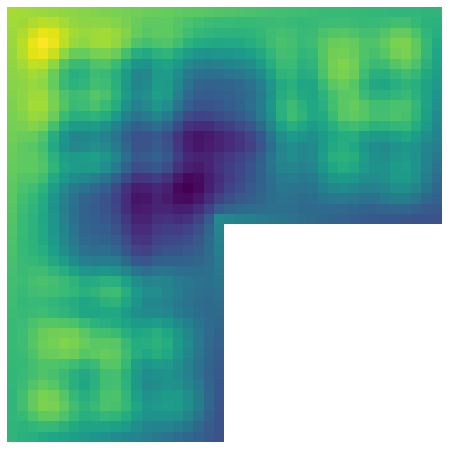

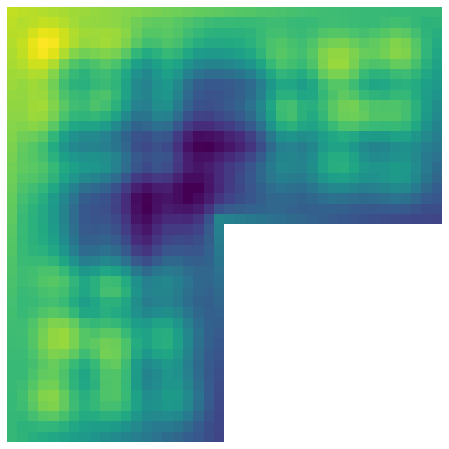

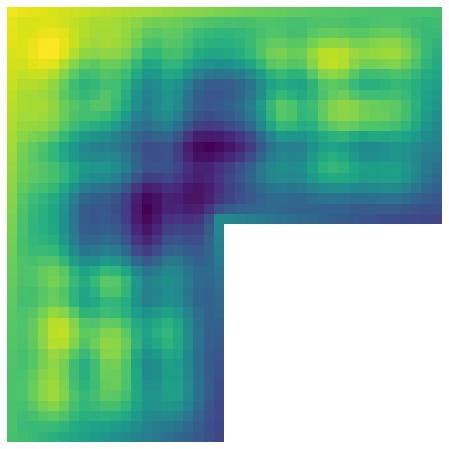

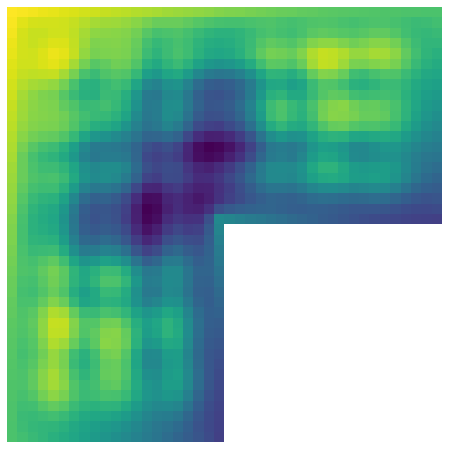

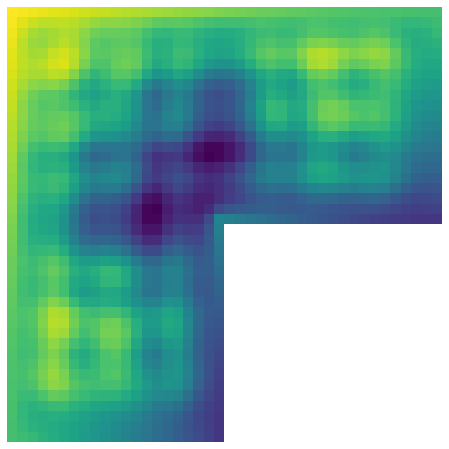

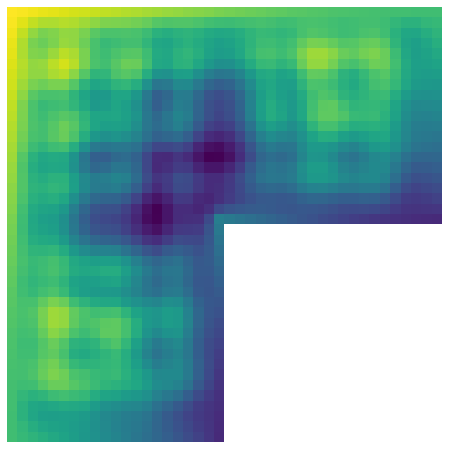

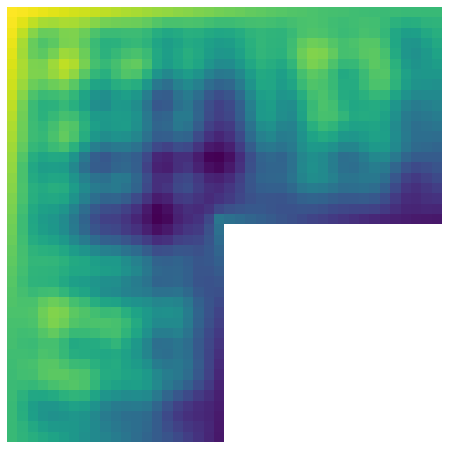

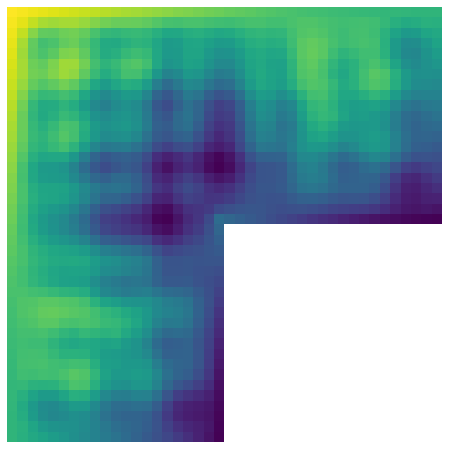

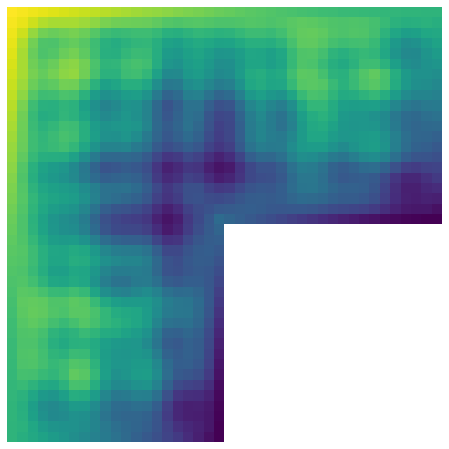

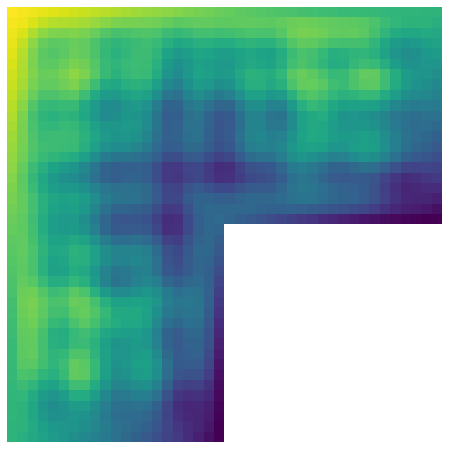

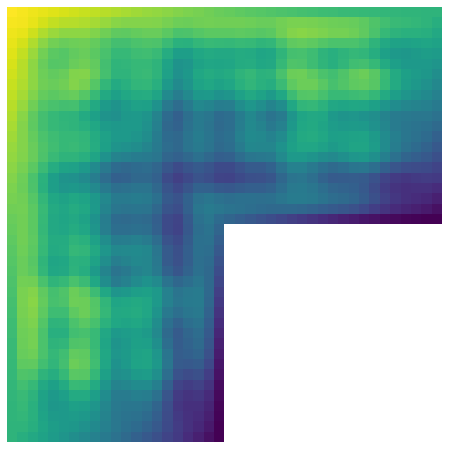

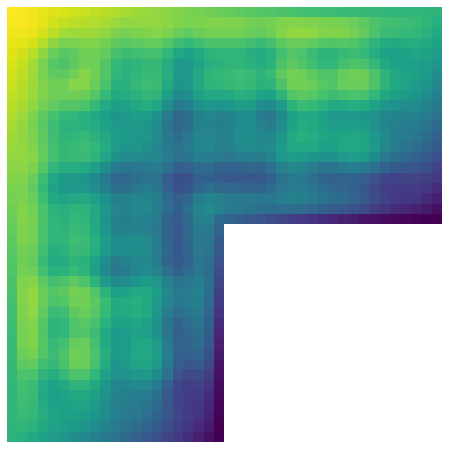

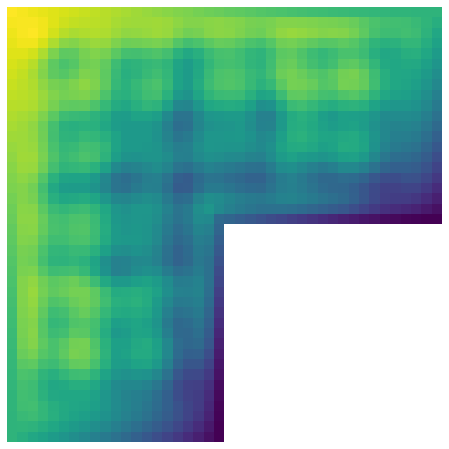

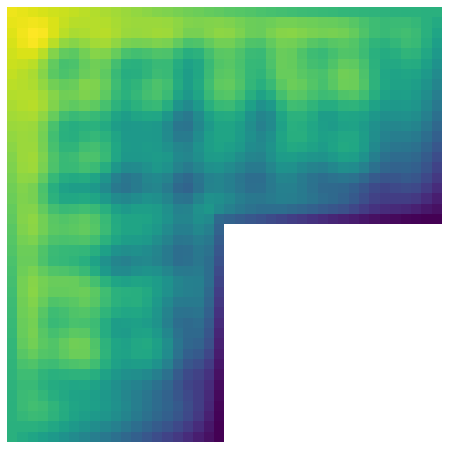

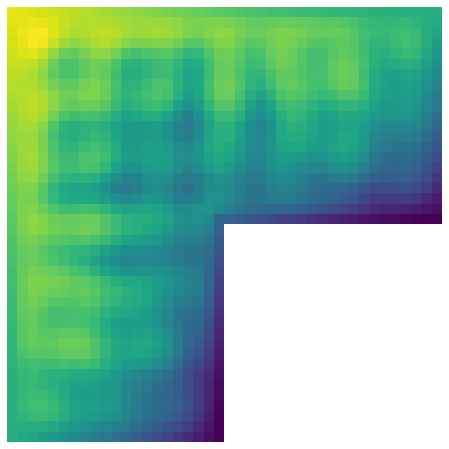

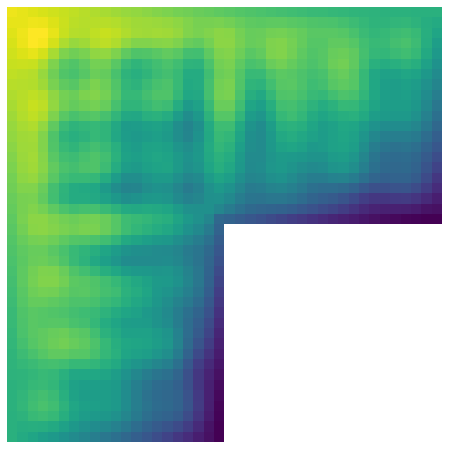

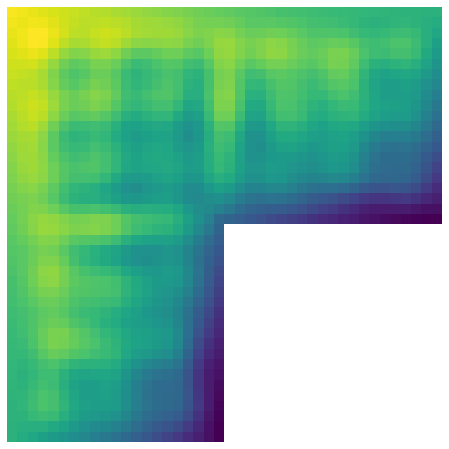

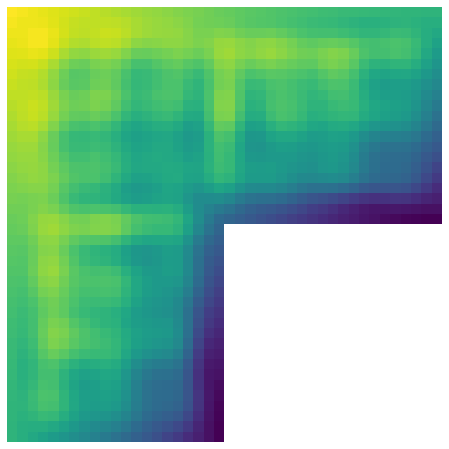

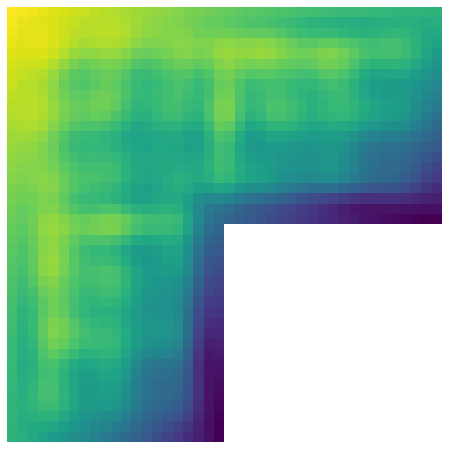

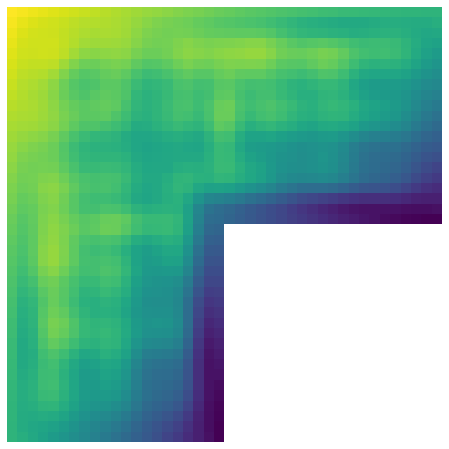

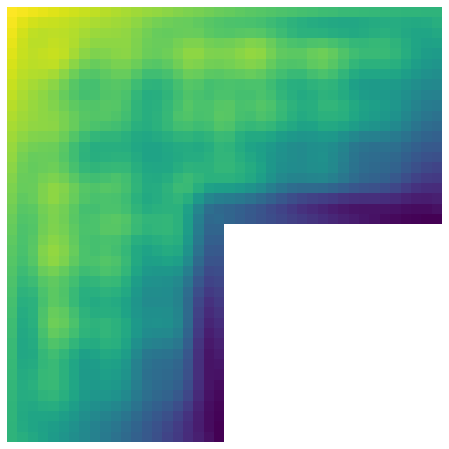

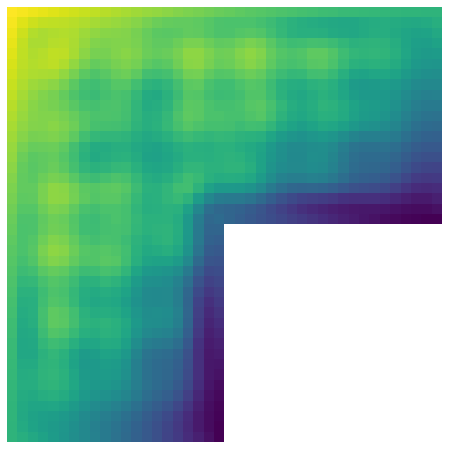

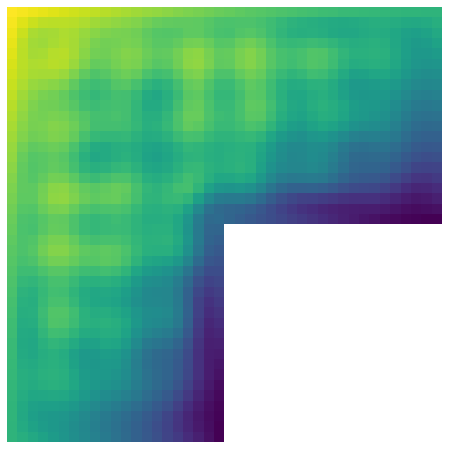

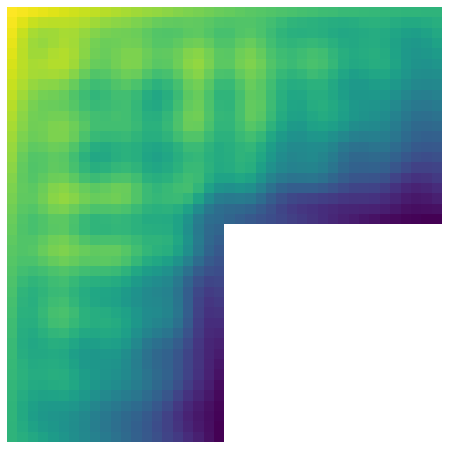

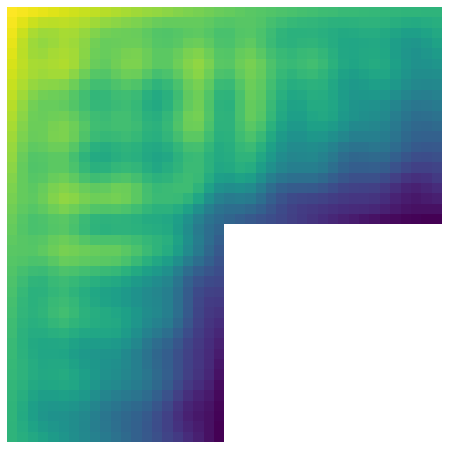

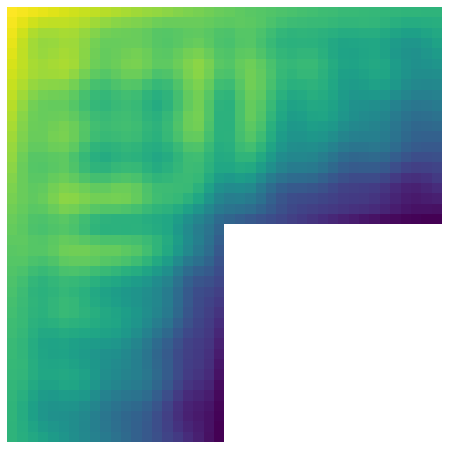

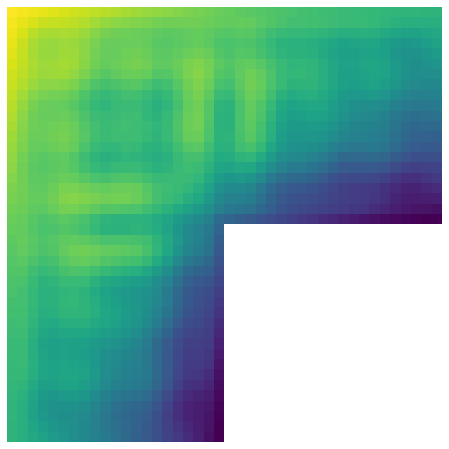

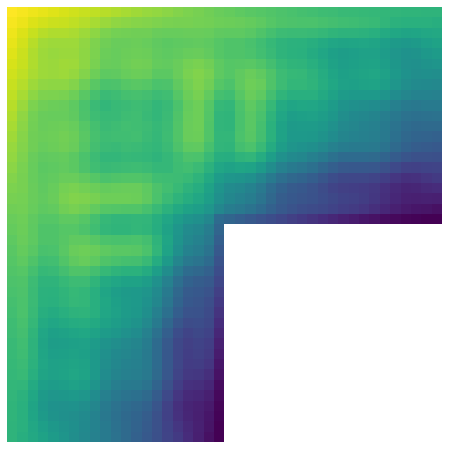

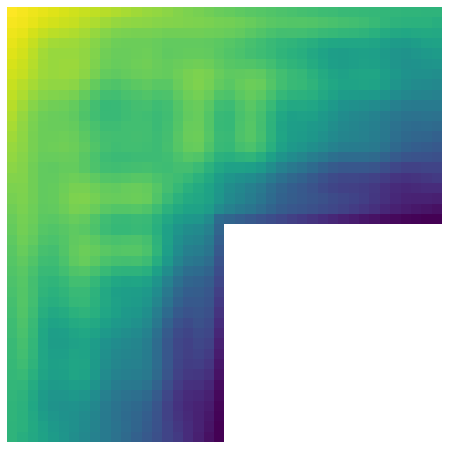

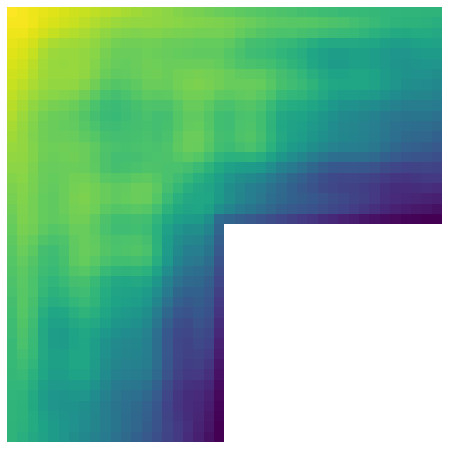

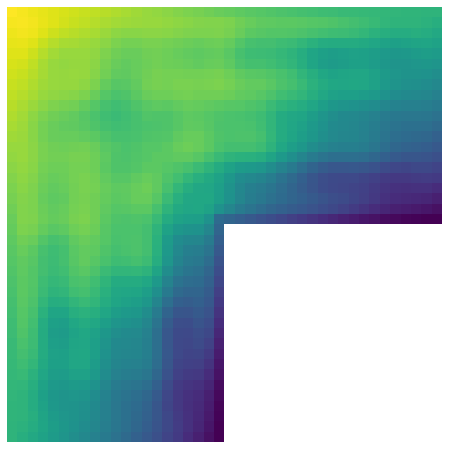

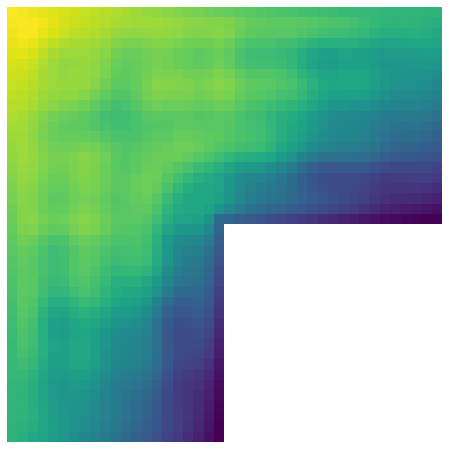

In [21]:
# Use the SciPy cg iterative solver to solve the system and generate iteration plots.

n, A, b = stencil_discretisation(0.05)

u = np.full(((2 * n) * (2 * n)), 1.0, dtype=np.float64)    

x, info = cg(A, b, x0=u, callback=plot_x, maxiter=64)

### Visualisation of the Solution

Below is a plot of the solution to the system as produced by the SciPy cg iterative solver.

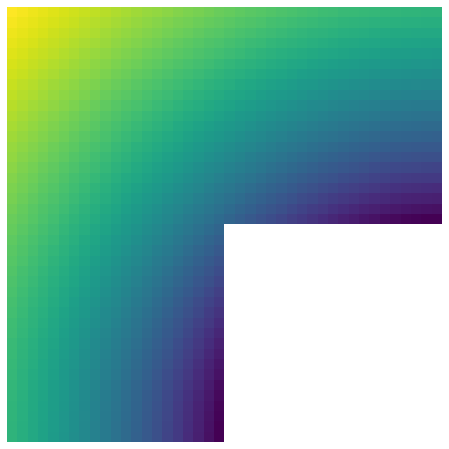

In [22]:
# Use the SciPy cg iterative solver to solve the system.

n, A, b = stencil_discretisation(0.05)

u = np.full(((2 * n) * (2 * n)), 1.0, dtype=np.float64)    

x, info = cg(A, b, x0=u)

plot_x(x)

As can be seen the plot above, the solution has converged to the interior points of the function defined on the domain boundaries.

## Convergence of CG with Increased Discretisation Points

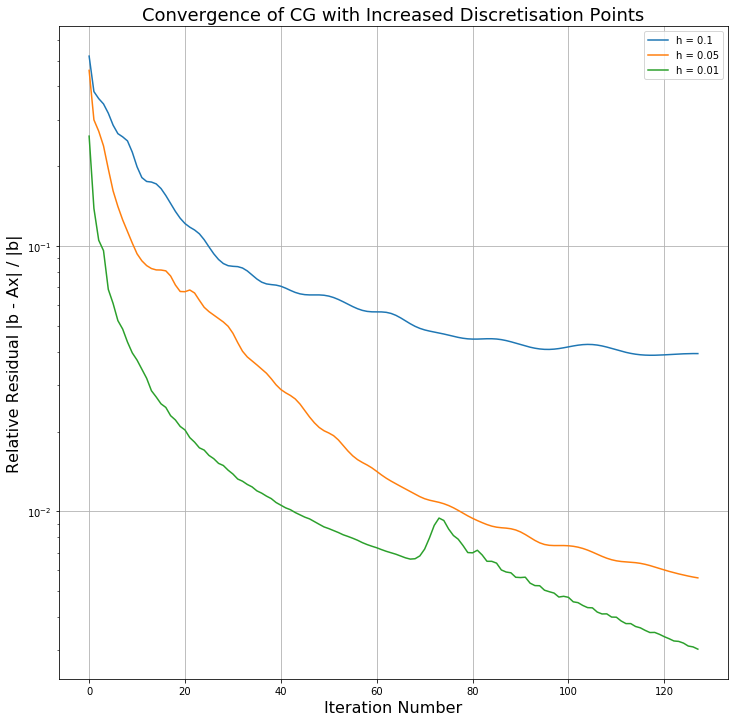

In [23]:
# Convergence of CG with increased Discretisation Points.

# Declare the maximum number of iterations for the study and the values of 'h' to consider.

MAXITER = 128

H = [0.1, 0.05, 0.01]

data = list([[], [], []])


# Conduct the SciPy iterative solver for each value of H.

for i, h in enumerate(H):

    n, A, b = stencil_discretisation(h)
    
    # The callback function is defined within the 'for loop' for access to A and b.
    
    def cb_function(x):
        data[i].append(np.linalg.norm(b - A * x) / np.linalg.norm(b))

    u = np.full(((2 * n) * (2 * n)), 1.0, dtype=np.float64)    

    x, info = cg(A, b, x0=u, callback=cb_function, maxiter=MAXITER)


# Plot the data.

fig = plt.figure(figsize=(12.0, 12.0))

plt.semilogy(range(MAXITER), data[0], label="h = 0.1")
plt.semilogy(range(MAXITER), data[1], label="h = 0.05")
plt.semilogy(range(MAXITER), data[2], label="h = 0.01")

plt.xlabel("Iteration Number", fontsize=16)
plt.ylabel("Relative Residual |b - Ax| / |b|", fontsize=16)

plt.title("Convergence of CG with Increased Discretisation Points", fontsize=18)

plt.legend()
plt.grid()
plt.show()

As can be seen from the plot above, as the grid size 'h' is reduced (increased discretisation points), the relative residual reduces faster. This is to be expected since a reduced value of 'h' will premit the spreading off data across the grid more quickly.

## Incomplete LU Factorisation (ILU) and CG Convergence

An investigation was carried out to understand the effect of drop tolerance of the ILU factorisation and CG convergence. The results are presented graphically and discussed below.

/opt/anaconda3/envs/phas0102/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:372: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


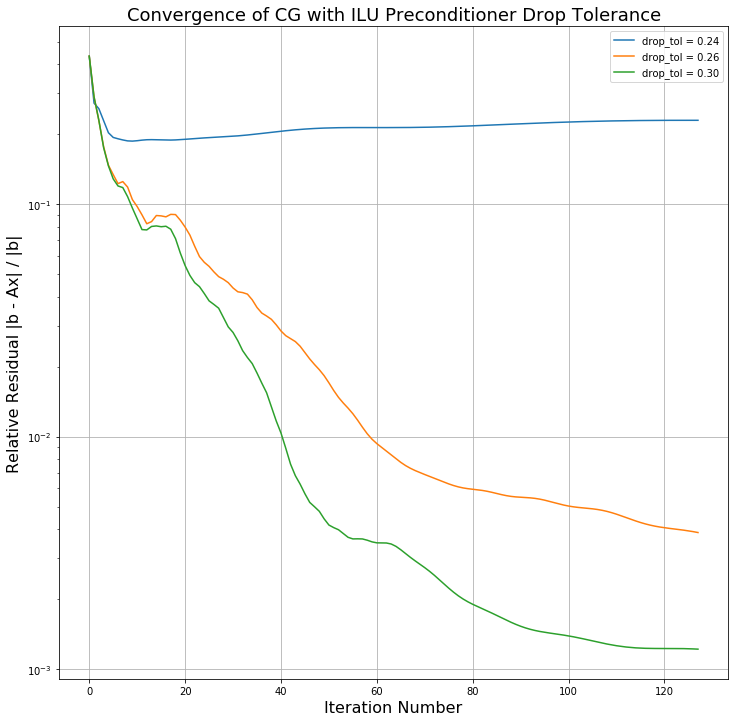

In [24]:
# Convergence of CG with ILU Preconditioner.

# Declare the maximum number of iterations and the value of 'h' to consider.

MAXITER = 128

H = 0.05

data = list([[], [], []])


# Declare the values of drop tolerance to consider.

DROP_TOL = [0.24, 0.26, 0.30]


# Conduct the SciPy iterative solver for each value of DROP_TOL.

for i, drop_tol in enumerate(DROP_TOL):

    n, A, b = stencil_discretisation(H)
    
    # The callback function is defined within the 'for loop' for access to A and b.
    
    def cb_function(x):
        data[i].append(np.linalg.norm(b - A * x) / np.linalg.norm(b))

    u = np.full(((2 * n) * (2 * n)), 1.0, dtype=np.float64)
    
    preconditioner = LinearOperator(((2 * n) * (2 * n), (2 * n) * (2 * n)), spilu(A, drop_tol=drop_tol, fill_factor=1.0).solve)

    x, info = cg(A, b, x0=u, callback=cb_function, maxiter=MAXITER, M=preconditioner)


# Plot the data.

fig = plt.figure(figsize=(12.0, 12.0))

plt.semilogy(range(MAXITER), data[0], label="drop_tol = 0.24")
plt.semilogy(range(MAXITER), data[1], label="drop_tol = 0.26")
plt.semilogy(range(MAXITER), data[2], label="drop_tol = 0.30")

plt.xlabel("Iteration Number", fontsize=16)
plt.ylabel("Relative Residual |b - Ax| / |b|", fontsize=16)

plt.title("Convergence of CG with ILU Preconditioner Drop Tolerance", fontsize=18)

plt.legend()
plt.grid()
plt.show()

Various values of drop tolerances were investigated to determine the effect on CG convergence for a fixed 'h' of 0.05.

From the previous investigation into the effect of the number of discretisation points on CG convergence, it can be determined that the relative residual dropped to 10e-2 after approximately 80 iterations (for 'h' = 0.05). From the plot above it can be determined that the relative residual dropped to the same value after 40 iterations with a drop tolerance of 0.3.

The SciPy spilu documentation states that the drop_tol should be 0 <= tol <= 1 for an incomplete LU decomposition. The investigation that was carried out determined that a drop_tol of 0 - 0.24 has negligible effect on improving CG convergence. And then a narrow band of 0.26 - 0.3 produced the most effective improvment in CG convergence. Values of drop_tol 0.3 - 1.0 did not appear to have any further benefit. This result is likely to be specific to the question domain and the specifics of the Matrix A.

# Question 2: Preconditioned Iterative Solvers - INITIAL APPROACH

**PLEASE DO NOT MARK THIS SECTION. I HAVE INCLUDED IT FOR COMPLETENESS AND TO ILLUSTRATE THE DIFFERENT APPROACHES I LOOKED INTO FOR ANSWERING THIS QUESTION. THERE IS NO DOCUMENTATION INCLUDED FOR THIS ABANDONED ATTEMPT AT ANSWERING QUESTION 2.**

## Program Description

## Program Structure

## Visualisation


In [25]:
def stencil_discretisation_v1(m, top_bc = None, bottom_bc = None, left_bc = None, right_bc = None):

    a = np.zeros((m * m, m * m))

    b = np.zeros((m, m))

    if (top_bc != None):
        b[0, :] = top_bc

    if (bottom_bc != None):
        b[m - 1, :] = bottom_bc
        
    if (left_bc != None):
        b[:, 0] = left_bc
        
    if (right_bc != None):
        b[:, m - 1] = right_bc

    for i in range(m * m):
        for j in range(m * m):
            
            if (i == j):
                
                a[i, j] = 4
                
                if (j - 1 > (j // m) * m - 1):
                    a[i, j - 1] = -1
                    
                if (j + 1 < (j // m + 1) * m):
                    a[i, j + 1] = -1
                    
                if (j + m < m * m):
                    a[i, j + m] = -1
                    
                if (j - m > -1):
                    a[i, j - m] = -1
                    
    return a, b.flatten()

In [26]:
M = 32

# Area 1 - Top Left

A1, b1 = stencil_discretisation_v1(M, top_bc=1, left_bc=1)

u1 = np.zeros((M * M))

x1, _ = cg(A1, b1, x0=u1)

x1 = x1.reshape(M, M)


# Area 2 - Top Right

A2, b2 = stencil_discretisation_v1(M, top_bc=1, right_bc=1, bottom_bc=1)

u2 = np.zeros((M * M))

x2, _ = cg(A2, b2, x0=u2)

x2 = x2.reshape(M, M)


# Area 3 - Bottom Left

A3, b3 = stencil_discretisation_v1(M, left_bc=1, right_bc=1, bottom_bc=1)

u3 = np.zeros((M * M))

x3, _ = cg(A3, b3, x0=u3)

x3 = x3.reshape(M, M)

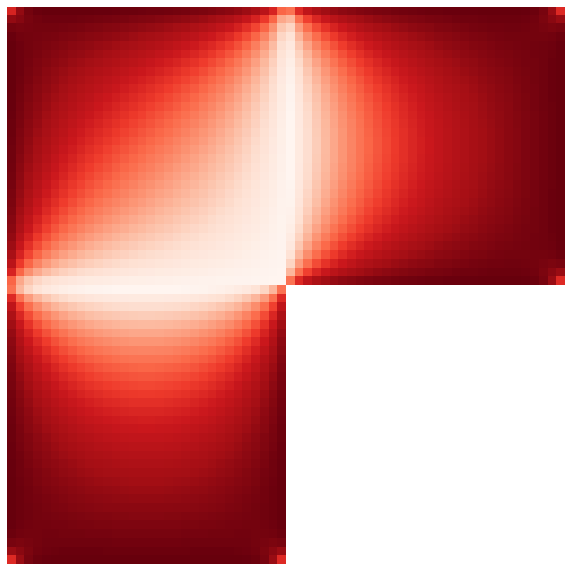

In [27]:
plt.figure(figsize=(10, 10.25))
plt.subplots_adjust(hspace=0, wspace=0)

plt.subplot(2, 2, 1)
plt.imshow(x1, cmap='Reds')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(x2, cmap='Reds')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(x3, cmap='Reds')
plt.axis('off')

plt.show()

In [28]:
def stencil_discretisation_v2(m, top_bc = None, bottom_bc = None, left_bc = None, right_bc = None):

    a = np.zeros((m * m, m * m))
    
    b = np.zeros((m, m))

    if (top_bc != None):
        b[0, :] = top_bc

    if (bottom_bc != None):
        b[m - 1, :] = bottom_bc
        
    if (left_bc != None):
        b[:, 0] = left_bc
        
    if (right_bc != None):
        b[:, m - 1] = right_bc

    for i in range(m * m):
        for j in range(m * m):
            
            if (i == j):
                
                a[i, j] = 4
                
                if (j - 1 > (j // m) * m - 1):
                    a[i, j - 1] = -1
                    
                if (j + 1 < (j // m + 1) * m):
                    a[i, j + 1] = -1

                if (j + m < m * m):
                    a[i, j + m] = -1
                    
                if (j - m > -1):
                    a[i, j - m] = -1

    return a, b.flatten()

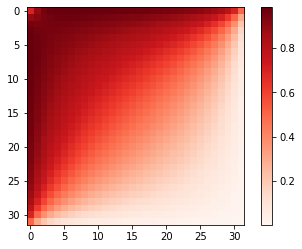

In [29]:
M = 32

A, b = stencil_discretisation_v2(M, top_bc=1, left_bc=1)

b.reshape(M, M)

u = np.zeros((M, M))

x, _ = cg(A, b.flatten(), u.flatten())

x = x.reshape(M, M)

plt.imshow(x, cmap='Reds')
plt.colorbar()
plt.show()